In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/GSoC-GENIE"

 autoencoder_model.h5   cumulative_history.json   GENIE.ipynb	     QuarkGluonDataset
'Copy of GENIE.ipynb'   data			  gnn_history.json   test-folder


In [3]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/GSoC-GENIE/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

# **Data Inspection**

In [14]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib to use internal math rendering
# plt.rcParams.update({
#     'text.usetex': False,  # Use internal mathtext
#     'font.family': 'serif',
# })

np.random.seed(42)

class HDF5SubDataset:
    def __init__(self, file_path, sample_percent):
        """
        Initialize the sub-dataset by storing the file path and the indices to sample.

        Parameters:
        - file_path (str): Path to the HDF5 file.
        - sample_percent (float): Fraction of the dataset to sample (e.g., 0.1 for 10%).
        """
        self.file_path = file_path
        with h5py.File(self.file_path, 'r') as f:
            self.total_samples = f['X_jets'].shape[0]
        sample_size = int(self.total_samples * sample_percent)
        print("Sample Size: ", sample_size)
        # Generate random indices and sort them for efficient slicing
        self.indices = np.sort(np.random.choice(self.total_samples, sample_size, replace=False))
        self.sample_size = sample_size

    def display_sample_event(self, sample_index=0):
        """
        Display a single sample event from the sub-dataset with a colorbar for each channel.

        Parameters:
        - sample_index (int): Index of the event to display from the sampled indices.
        """
        with h5py.File(self.file_path, 'r') as f:
            # Get the event and original index from the full dataset
            orig_index = self.indices[sample_index]
            sample_event = f['X_jets'][orig_index]
        channel_names = ['ECAL', 'HCAL', 'Tracks']

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        for i, ax in enumerate(axes):
            img = ax.imshow(sample_event[:, :, i], cmap='jet')
            ax.set_title(f"${channel_names[i]}$ (Channel {i})", fontsize=14)
            ax.axis('off')
            fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

        plt.suptitle(f"Sample Event | Original Index = {orig_index}", fontsize=18)
        plt.subplots_adjust(top=0.95)
        plt.savefig("/content/drive/MyDrive/GSoC-GENIE/Data-Inspection/sample_event.png", dpi=300)
        plt.show()

    def display_distributions(self):
        """
        Display histograms for the scalar parameters using the sampled indices.
        """
        with h5py.File(self.file_path, 'r') as f:
            m0 = f['m0'][self.indices]
            pt = f['pt'][self.indices]
            y = f['y'][self.indices]

        scalar_keys = ['m0', 'pt', 'y']
        # Define LaTeX labels for the scalar parameters
        scalar_labels = {
            'm0': r"$m_0$",
            'pt': r"$p_T$",
            'y': r"$y$"
        }

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for ax, key in zip(axes, scalar_keys):
            data = None
            if key == 'm0':
                data = m0
            elif key == 'pt':
                data = pt
            elif key == 'y':
                data = y
            ax.hist(data, bins=50, color="b", edgecolor="black", alpha=0.7)
            ax.set_title(f"Histogram of {scalar_labels[key]}", fontsize=14)
            ax.set_xlabel(f"{scalar_labels[key]}", fontsize=12)
            ax.set_ylabel("Frequency", fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

        super_title = ("Distributions of Scalar Parameters.\n"
                       f"Subsample Size: {self.sample_size} / {self.total_samples}")
        plt.suptitle(super_title, fontsize=18)
        plt.subplots_adjust(top=0.85)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("/content/drive/MyDrive/GSoC-GENIE/Data-Inspection/sub_param_distrib.png", dpi=300)
        plt.show()

In [15]:
import h5py
import numpy as np

# File path for the dataset
my_dir = "/content/drive/MyDrive/GSoC-GENIE/"
data_path = my_dir + 'data/quark-gluon_data-set_n139306.hdf5'

# Open the HDF5 file for inspection
with h5py.File(data_path, 'r') as f:
    # Retrieve and print all keys (channels) in the dataset
    keys = list(f.keys())
    print("Dataset keys (channels):", keys)

    # Print the shape of the dataset for each key
    for key in keys:
        data_shape = f[key].shape
        print(f"Channel: {key}, Shape: {data_shape}")

Dataset keys (channels): ['X_jets', 'm0', 'pt', 'y']
Channel: X_jets, Shape: (139306, 125, 125, 3)
Channel: m0, Shape: (139306,)
Channel: pt, Shape: (139306,)
Channel: y, Shape: (139306,)


Sample Size:  6965


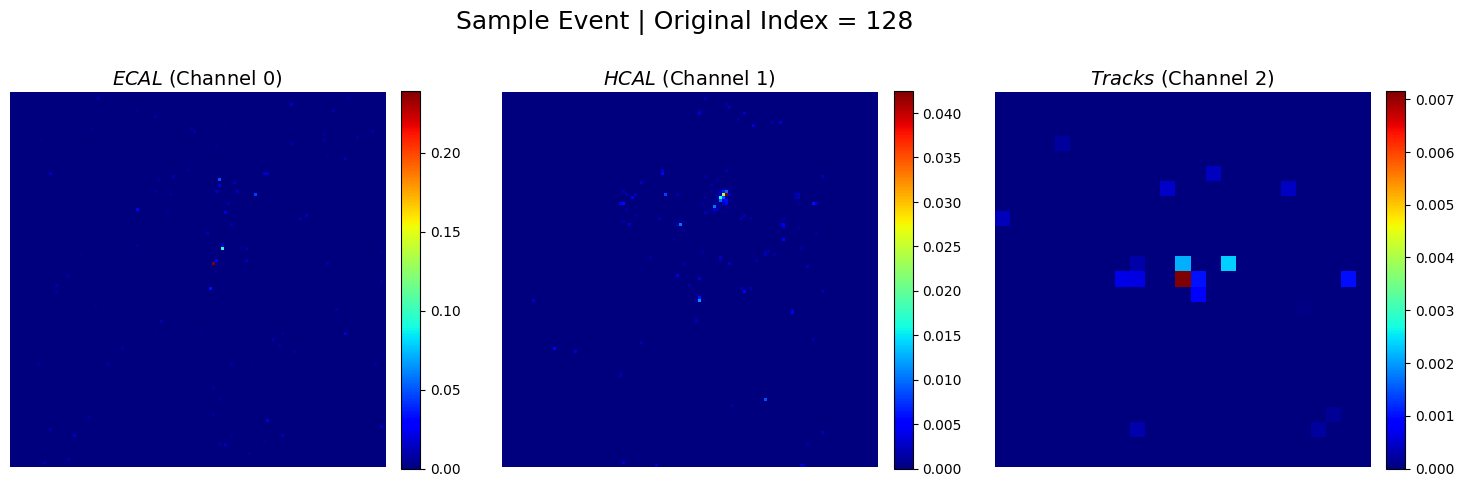

In [16]:
# Instantiate the sub-dataset with x% sampling
sub_dataset = HDF5SubDataset(data_path, sample_percent=0.05)

# Display a specific sample event (modify sample_index as needed)
sub_dataset.display_sample_event(sample_index=5)

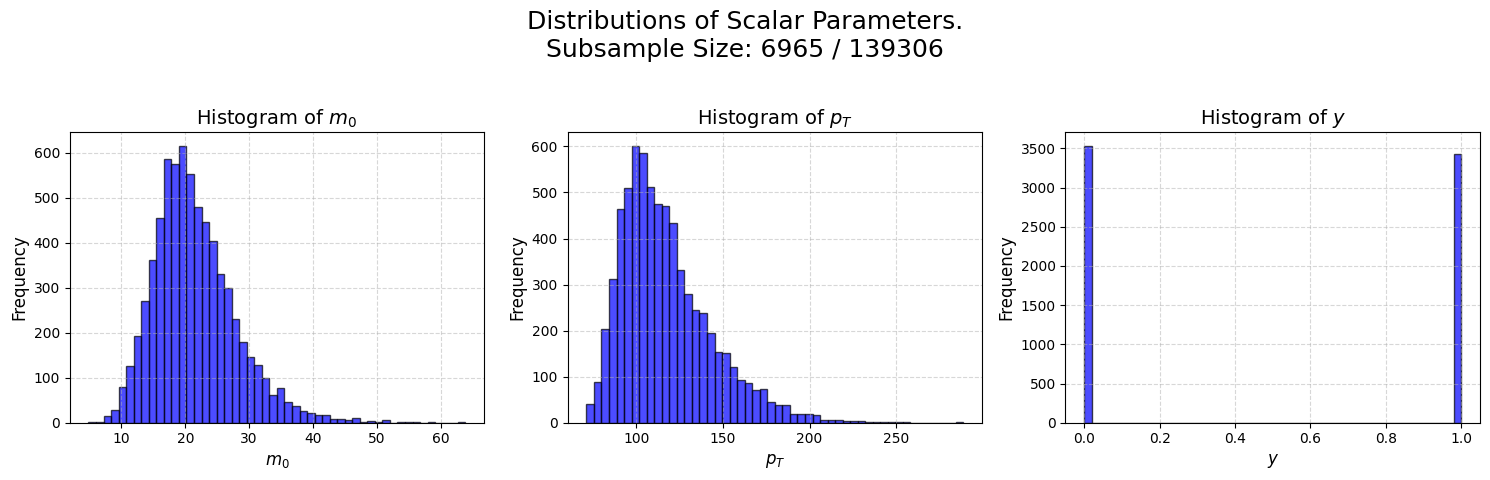

In [17]:
# Display the distributions of scalar parameters from the sampled indices
sub_dataset.display_distributions()

---

# **Common Task 1: Auto-encoder for Quark/Gluon Event Reconstruction**

## **Preprocessing, Model Definition, and Initial Training**

In [18]:
import os
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

tf.config.run_functions_eagerly(True)

# Define directory paths.
my_dir = "/content/drive/MyDrive/GSoC-GENIE/"
data_path = os.path.join(my_dir, "data", "quark-gluon_data-set_n139306.hdf5")
model_path = os.path.join(my_dir, "autoencoder_model.h5")
history_file = os.path.join(my_dir, "cumulative_history.json")

# Configure GPU memory growth if a GPU is available.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Retrieve total number of samples.
with h5py.File(data_path, 'r') as f:
    total_samples = f['X_jets'].shape[0]
print("Total samples in dataset:", total_samples)

# Load a subsample of the dataset.
n_samples = int(0.05 * total_samples)
print("Using subsample of", n_samples, "samples.")
with h5py.File(data_path, 'r') as f:
    X = f['X_jets'][:n_samples]  # Shape: (n_samples, 125, 125, 3)

# Apply per-image normalization.
X_norm = np.array([img / np.max(img) if np.max(img) > 0 else img for img in X])

# Split data into training and testing sets (80/20 split).
split = int(0.8 * n_samples)
X_train = X_norm[:split]
X_test = X_norm[split:]

# Custom callback to persist training history and print cumulative epoch count.
class PersistentHistory(tf.keras.callbacks.Callback):
    def __init__(self, history_file):
        super().__init__()
        self.history_file = history_file
        if os.path.exists(self.history_file):
            with open(self.history_file, "r") as f:
                self.cumulative_history = json.load(f)
        else:
            self.cumulative_history = {"loss": [], "val_loss": []}

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        val_loss = logs.get("val_loss")
        # Convert to float; if eager execution is disabled, use backend.get_value.
        try:
            loss_val = float(loss)
        except Exception:
            loss_val = float(tf.keras.backend.get_value(loss))
        try:
            val_loss_val = float(val_loss)
        except Exception:
            val_loss_val = float(tf.keras.backend.get_value(val_loss))

        self.cumulative_history["loss"].append(loss_val)
        self.cumulative_history["val_loss"].append(val_loss_val)
        with open(self.history_file, "w") as f:
            json.dump(self.cumulative_history, f)
        # print("Cumulative epochs trained:", len(self.cumulative_history["loss"]))

# Check if a saved model exists; load it if available, else build a new model.
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    # Reinitialize the optimizer by creating a new instance.
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
    print("Loaded model from", model_path)
else:
    # Define the autoencoder architecture.
    input_img = layers.Input(shape=(125, 125, 3))
    # Encoder.
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    # Decoder.
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    # Crop output to match input dimensions.
    decoded = layers.Cropping2D(cropping=((1, 2), (1, 2)))(x)

    model = models.Model(input_img, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')

    # Train the model for initial epochs.
    initial_epochs = 1
    persistent_history = PersistentHistory(history_file=history_file)
    history = model.fit(X_train, X_train,
                        epochs=initial_epochs,
                        batch_size=8,
                        shuffle=True,
                        validation_data=(X_test, X_test),
                        callbacks=[persistent_history])
    # Save the model after initial training.
    model.save(model_path)
    print("Model saved to", model_path)

Total samples in dataset: 139306
Using subsample of 6965 samples.


Loaded model from /content/drive/MyDrive/GSoC-GENIE/autoencoder_model.h5


## **Model Architecture Diagram**

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 125, 125, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 125, 125, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 63, 63, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │             435 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 125, 125, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,795 (14.82 KB)

 Trainable params: 3,795 (14.82 KB)

 Non-trainable params: 0 (0.00 B)

**Note:** We here focus on the general scheme rather than perfection of the results.

A simple Autoencoder Model was trained on only 5% of the total data for 50 epochs (though the model is able to provide not-so-bad reconstructions with as few as 5 epochs of training).

The results displayed below shed light on the general success in reconstructions, despite using a very small subsample of the data available, and a relatively too simple AE model, and running the whole workflow on Google Colab free resources.

We would expect significant improvements when utlizing the rest of the data avaiable in the dataset (the remaining 95%!), but we avoid further working on this, as this would involve optimizations in data handling and parallelization. We also suspect that further tuninng the architecture of the model, in addition to availability of extra computational resources for additional epochs of training, would largely benefit the results.  

## **Additional Training**

In [ ]:
# Continue training the loaded model for additional epochs.
additional_epochs = 25
persistent_history = PersistentHistory(history_file=history_file)
history = model.fit(X_train, X_train,
                    epochs=additional_epochs,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    callbacks=[persistent_history])
# Save the updated model.
model.save(model_path)
print("Model updated and saved to", model_path)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 331s 474ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 2/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 489s 702ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 3/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 449s 625ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 380s 546ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 5/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 299s 428ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 319s 424ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 7/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 304s 436ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 305s 412ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 281s 403ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 306s 439ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 11/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 294s 399ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 12

Model updated and saved to /content/drive/MyDrive/GSoC-GENIE/autoencoder_model.h5


The autoencoder was first trained for 25 epochs and its weights were saved. In a subsequent session, the saved model was loaded and recompiled with a new instance of the Adam optimizer, which should reset its internal state while preserving the learned weights. The model was then further trained for an additional 25 epochs.

Although the optimizer's internal variables (such as momentum and adaptive learning rate adjustments) were reinitialized, this approach is expected to yield a final output that is nearly equivalent to training the model continuously for 50 epochs, with only minor differences in the training dynamics at the beginning of the resumed training phase.

This approach was implemented due to some constraints and computational efficiency considerations when running experiments in Colab, in addition to the large problem size.

## **Loss Curves**

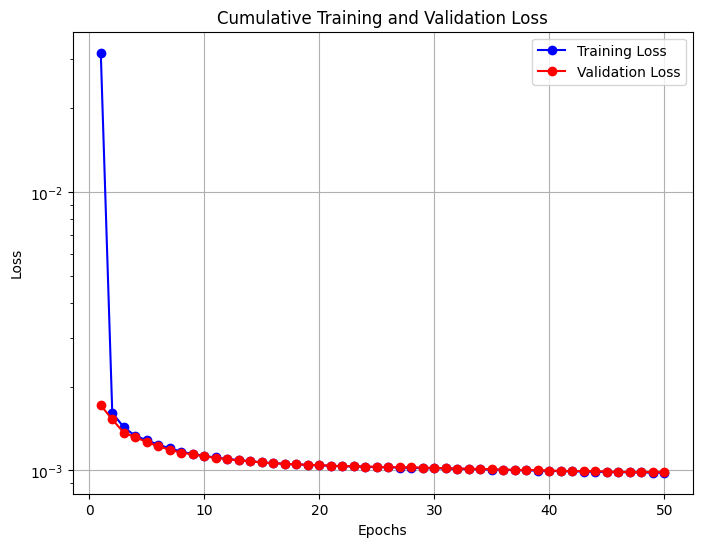

In [20]:
import json
import matplotlib.pyplot as plt
from pprint import pprint

# Load the cumulative training history from the JSON file.
with open(history_file, "r") as f:
    cumulative_history = json.load(f)

# Display the contents in a readable format.
# print("Cumulative History Contents:")
# pprint(cumulative_history)

# Define the epoch numbers.
epochs = range(1, len(cumulative_history["loss"]) + 1)

# Plot the training and validation loss curves.
plt.figure(figsize=(8, 6))
plt.plot(epochs, cumulative_history["loss"], "-o", color="b", label="Training Loss")
plt.plot(epochs, cumulative_history["val_loss"], "-o", color="r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Cumulative Training and Validation Loss")
plt.yscale("log")
plt.legend()
plt.grid()
plt.savefig("/content/drive/MyDrive/GSoC-GENIE/Common-Task-1/loss_curves.png", dpi=300)
plt.show()

## **Sample Reconstructions**

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


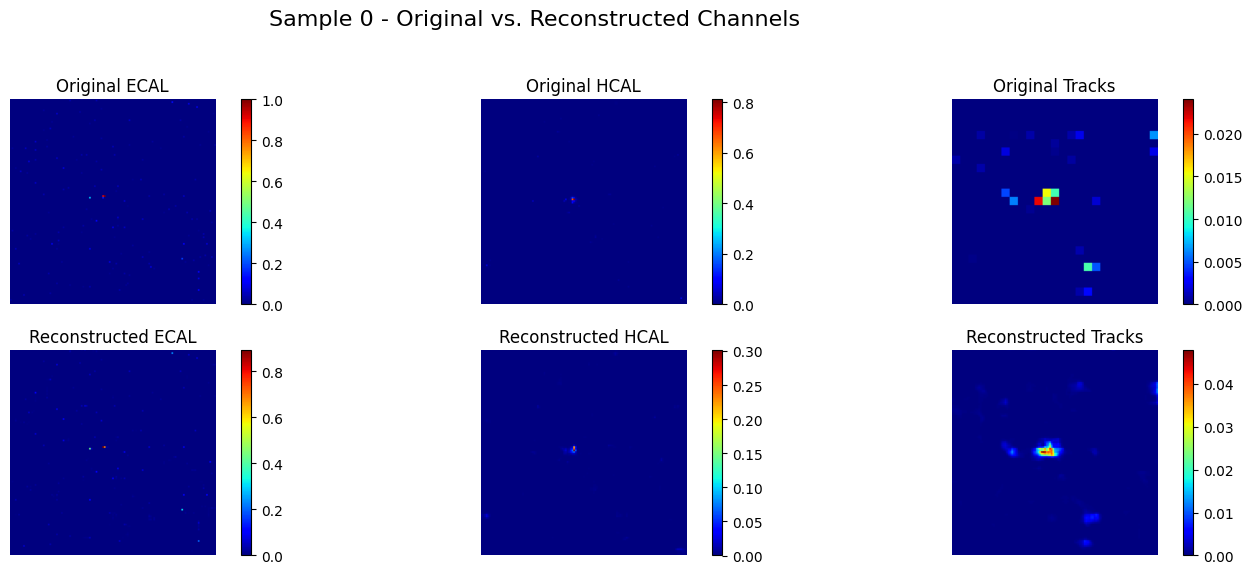

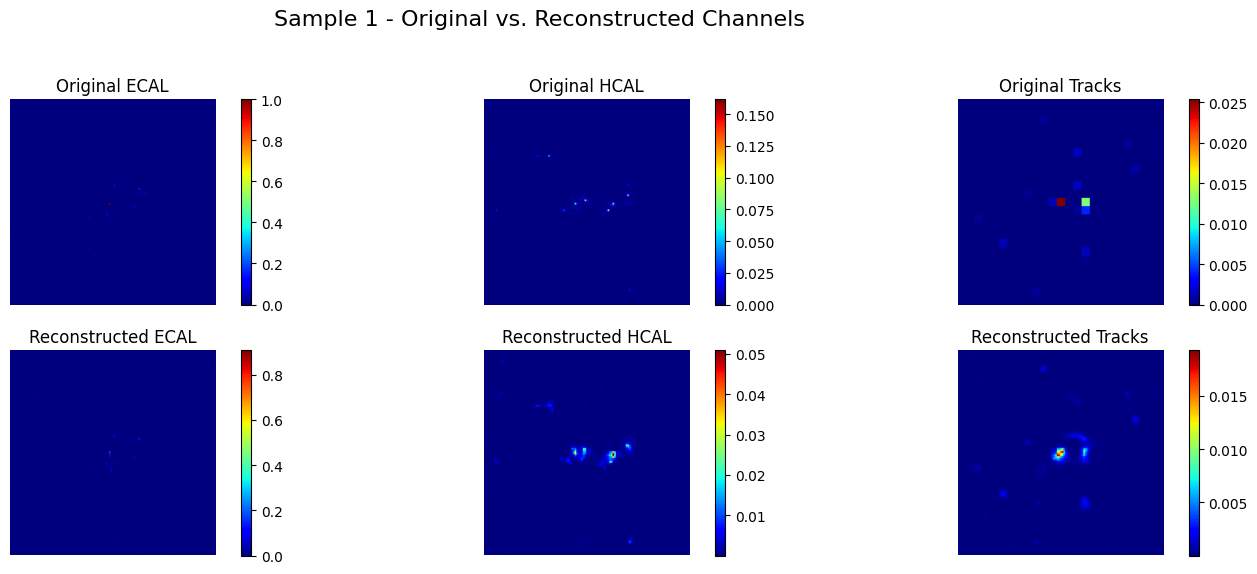

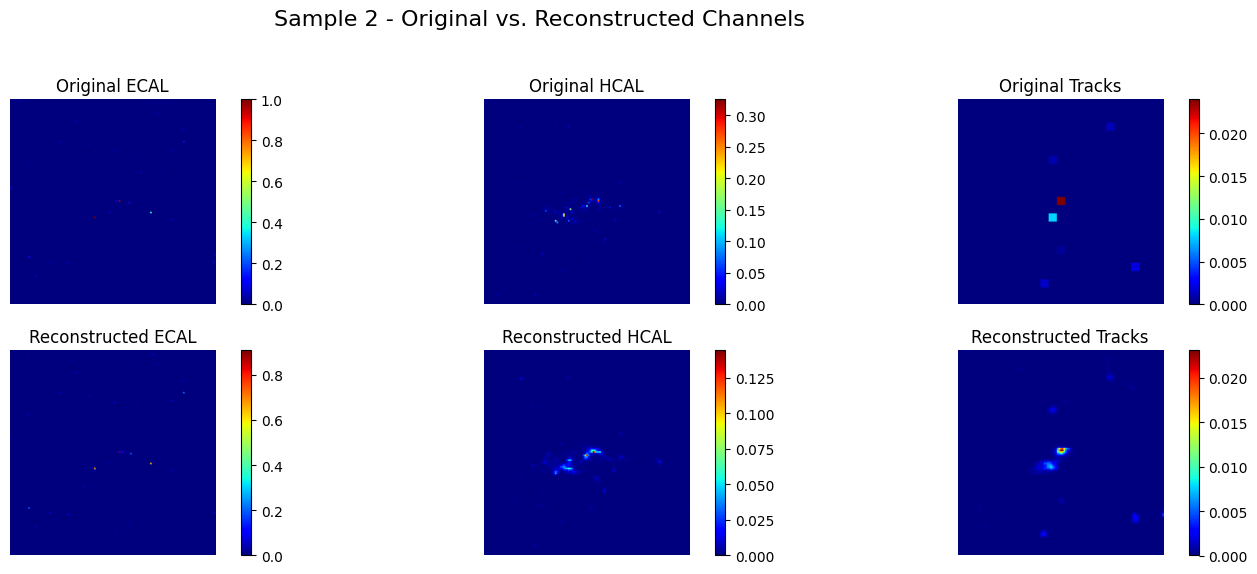

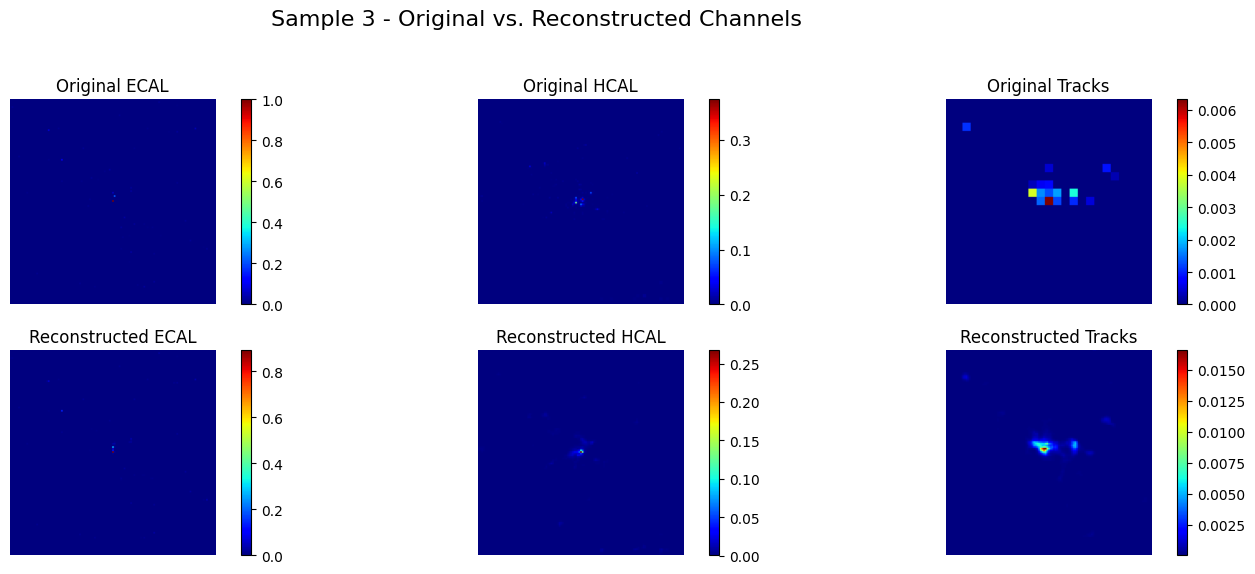

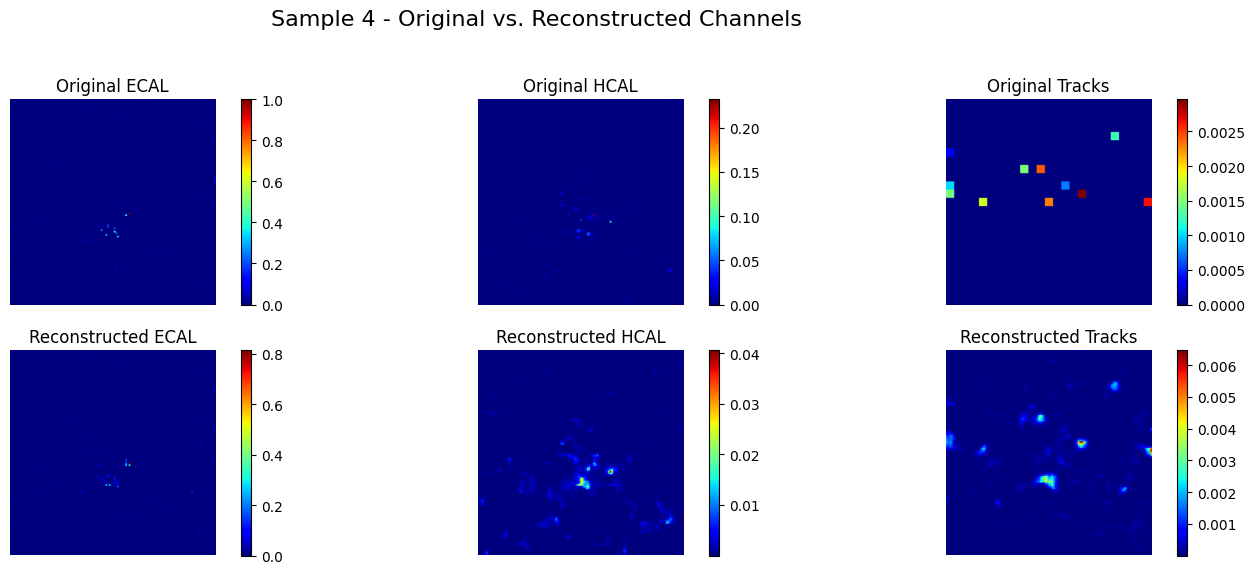

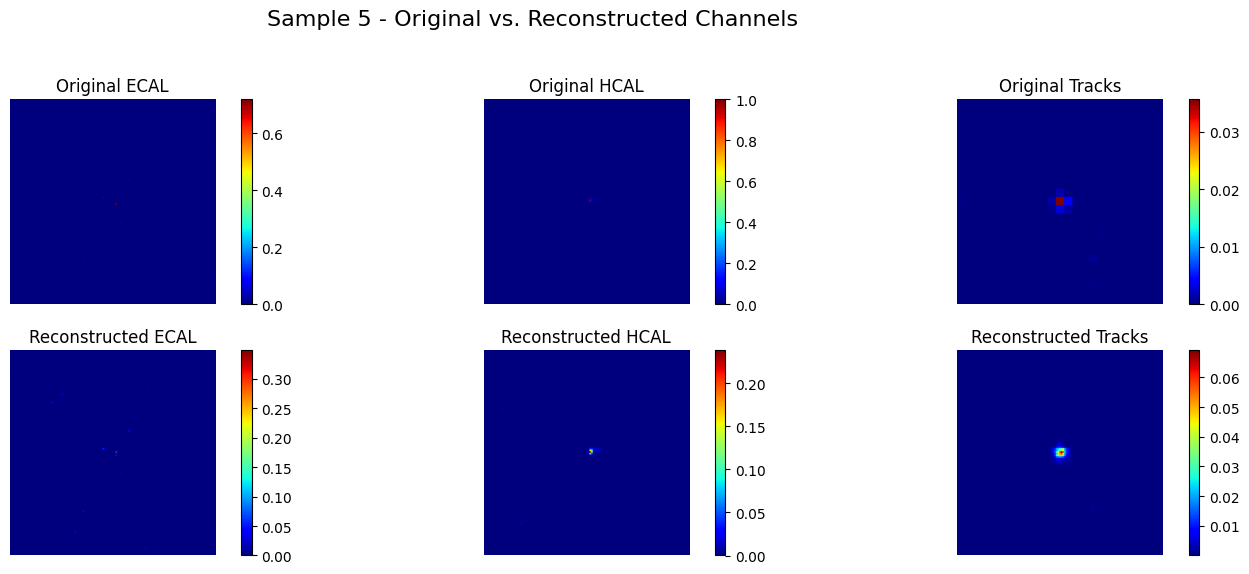

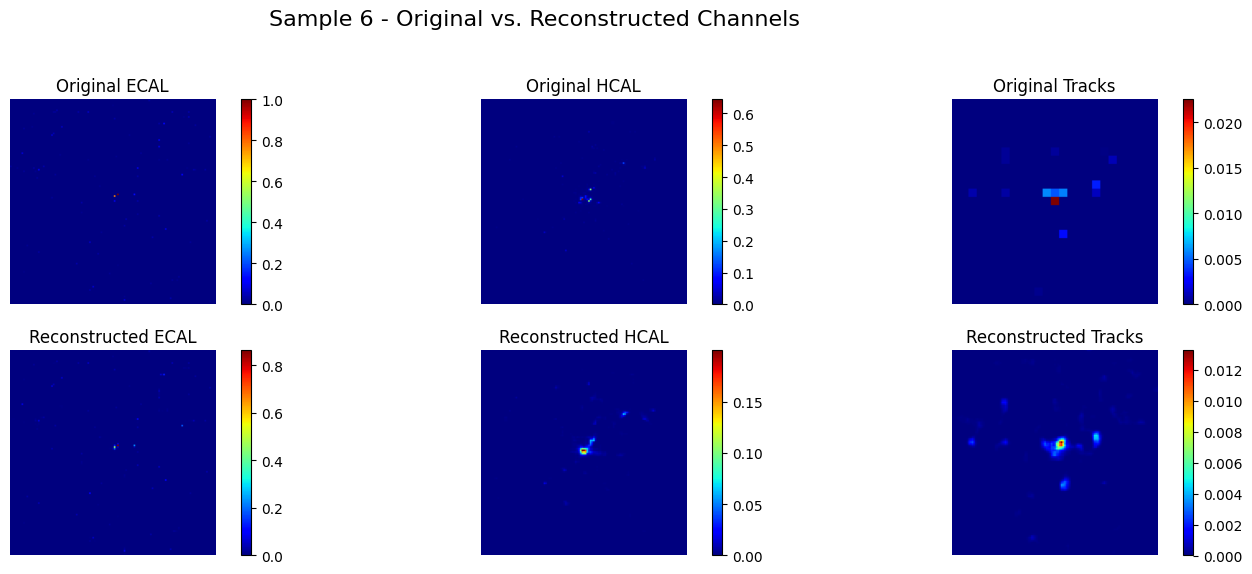

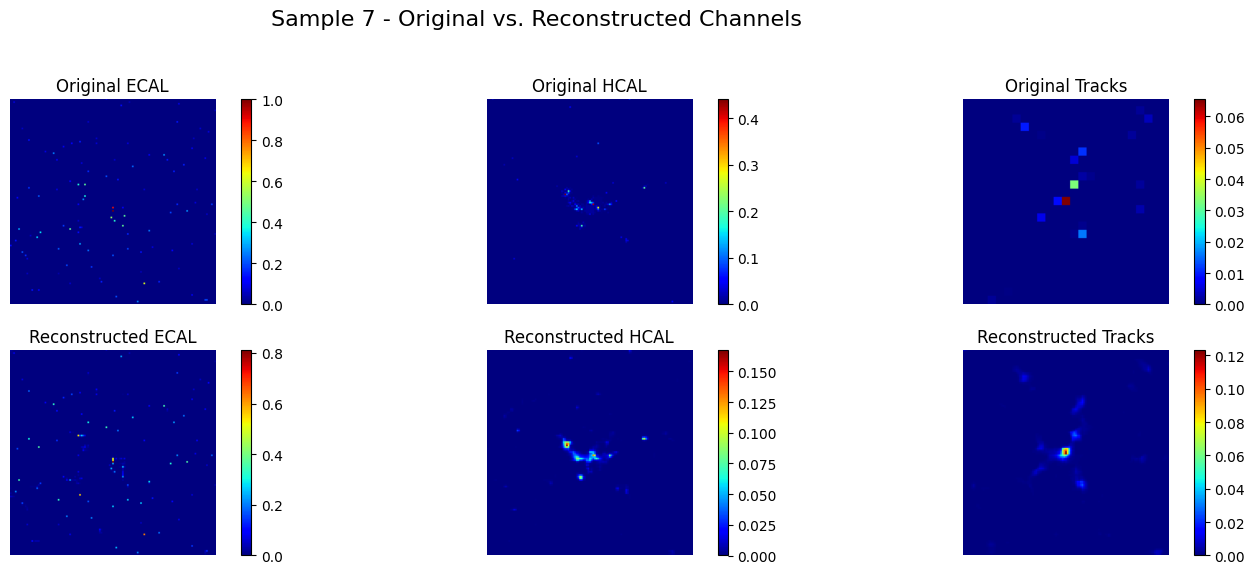

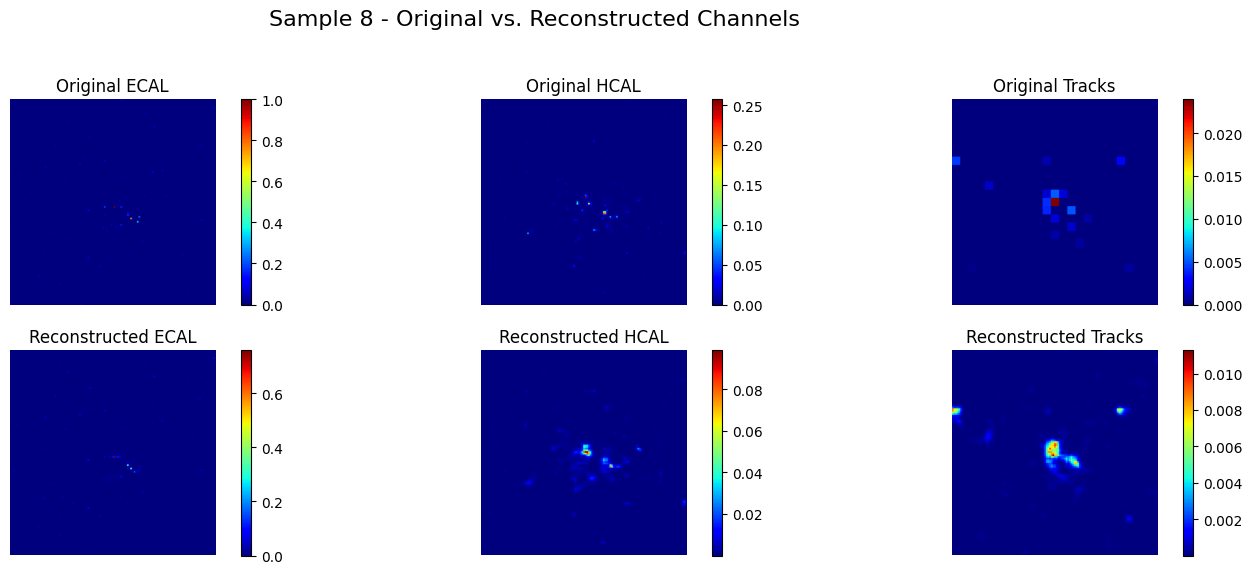

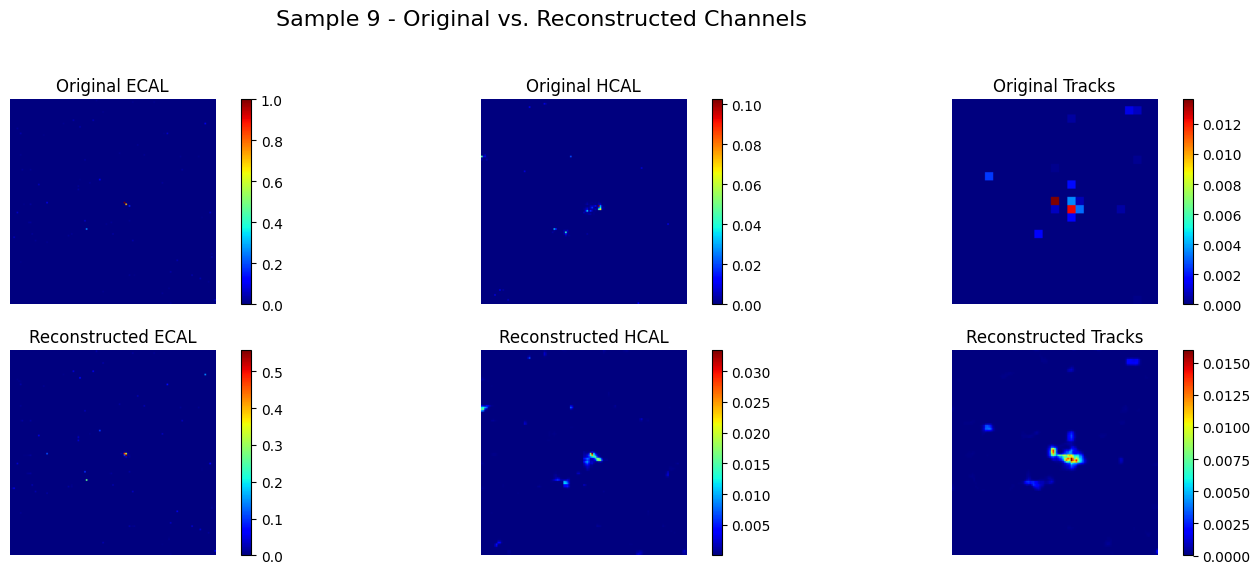

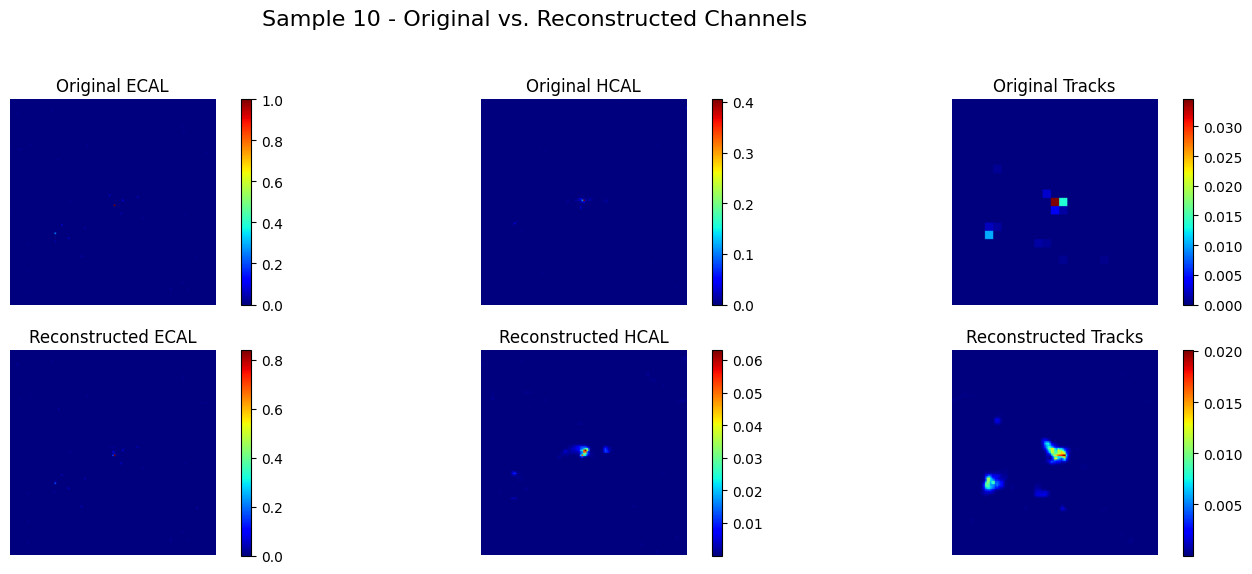

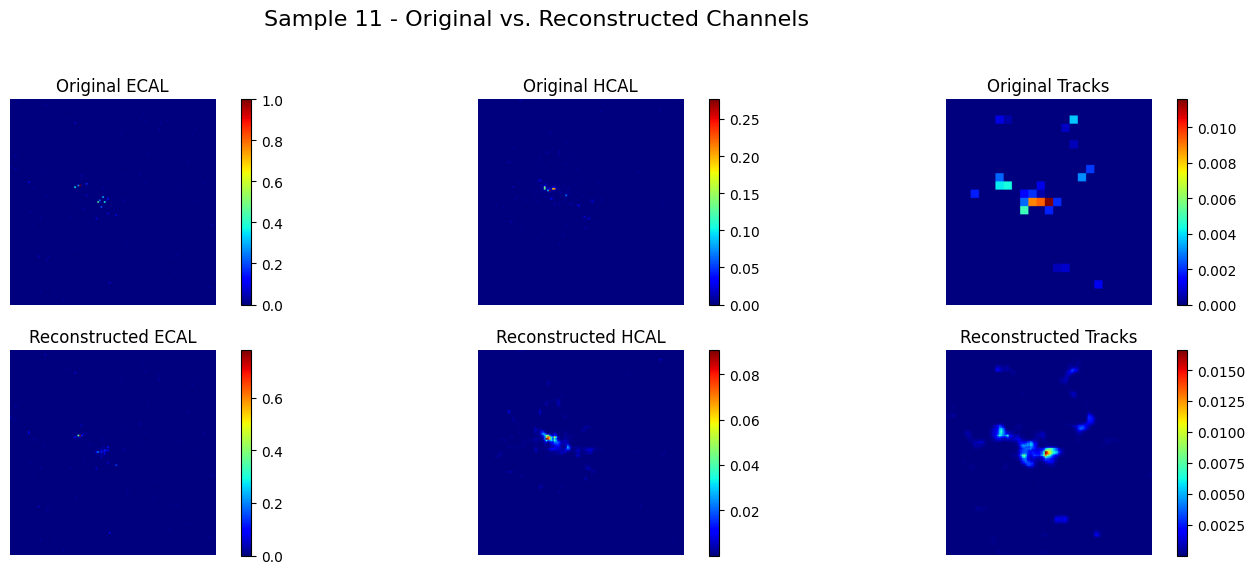

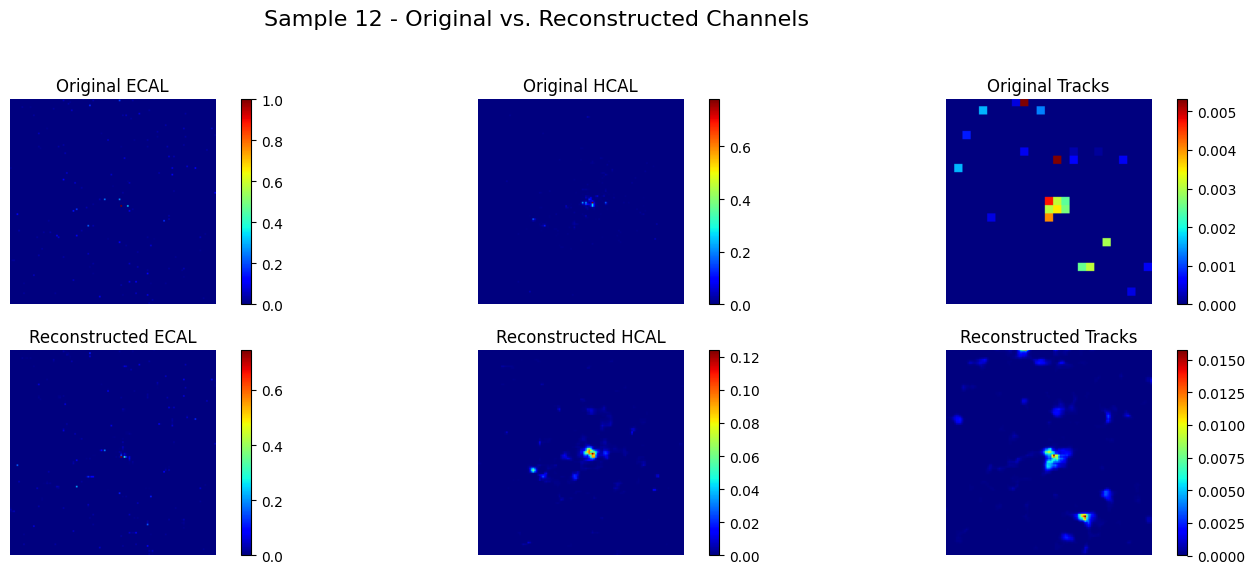

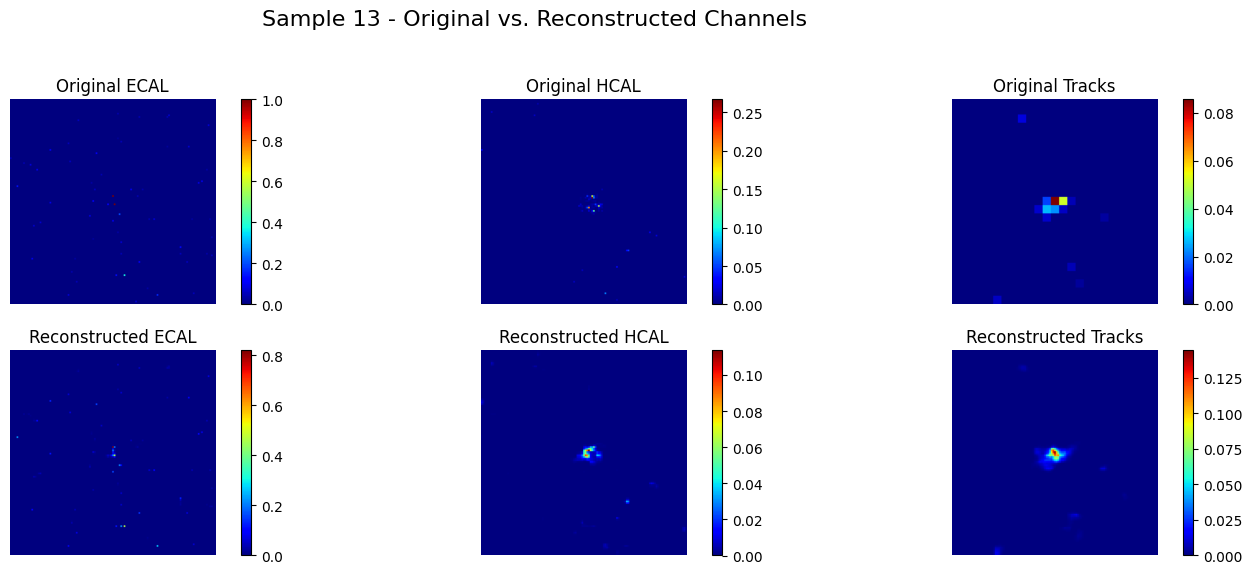

In [21]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the model path.
model_path = "/content/drive/MyDrive/GSoC-GENIE/autoencoder_model.h5"

# Load the saved model.
model = tf.keras.models.load_model(model_path)
model.compile(optimizer='adam', loss='binary_crossentropy')

# Generate reconstructions for a small test batch.
reconstructed = model.predict(X_test[:15])

# Display a channel-by-channel comparison with colorbars.
channels = ["ECAL", "HCAL", "Tracks"]
num_examples = 14  # Number of examples to display.
for i in range(num_examples):
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    for ch in range(3):
        # Display original image.
        im_orig = axes[0, ch].imshow(X_test[i][:, :, ch], cmap='jet')
        axes[0, ch].set_title(f"Original {channels[ch]}", fontsize=12)
        axes[0, ch].axis('off')
        fig.colorbar(im_orig, ax=axes[0, ch])

        # Display reconstructed image.
        im_recon = axes[1, ch].imshow(reconstructed[i][:, :, ch], cmap='jet')
        axes[1, ch].set_title(f"Reconstructed {channels[ch]}", fontsize=12)
        axes[1, ch].axis('off')
        fig.colorbar(im_recon, ax=axes[1, ch])

    plt.suptitle(f"Sample {i} - Original vs. Reconstructed Channels", fontsize=16)
    fig.subplots_adjust(top=0.88)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("\n")


In [23]:
# # Saving subsample images
# save_dir = "/content/drive/MyDrive/GSoC-GENIE/Common-Task-1"

# for i in range(num_examples):
#     fig, axes = plt.subplots(2, 3, figsize=(15, 6))
#     for ch in range(3):
#         im_orig = axes[0, ch].imshow(X_test[i][:, :, ch], cmap='jet')
#         axes[0, ch].set_title(f"Original {channels[ch]}", fontsize=12)
#         axes[0, ch].axis('off')
#         fig.colorbar(im_orig, ax=axes[0, ch])

#         im_recon = axes[1, ch].imshow(reconstructed[i][:, :, ch], cmap='jet')
#         axes[1, ch].set_title(f"Reconstructed {channels[ch]}", fontsize=12)
#         axes[1, ch].axis('off')
#         fig.colorbar(im_recon, ax=axes[1, ch])

#     plt.suptitle(f"Sample {i} - Original vs. Reconstructed Channels", fontsize=16)
#     fig.subplots_adjust(top=0.88)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#     filename = os.path.join(save_dir, f"samples_{i}.png")
#     plt.savefig(filename, dpi=300)

#     plt.show()
#     print("\n")

## **Resources**
- [Learning Particle Physics by Example:
Location-Aware Generative Adversarial Networks for
Physics Synthesis](https://arxiv.org/pdf/1701.05927)
- [Jet-Images: Computer Vision Inspired Techniques for Jet Tagging](https://arxiv.org/abs/1407.5675)
- [Investigation of Autoencoders for Jet Images
in Particle Physics](https://lup.lub.lu.se/luur/download?func=downloadFile&recordOId=9041079&fileOId=9043443)

---

# **Common Task 2: Jets as Graphs**

## **Best Model | Training**

In [26]:
# !pip install torch_geometric

In [27]:
import os
import h5py
import numpy as np
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# Function to convert an image into a graph representation.
def image_to_graph(image, k=5):
    # A mask is generated for pixels with nonzero values across channels.
    mask = np.any(image > 0, axis=-1)
    coords = np.argwhere(mask)

    # If no nonzero pixels are found, a dummy node is created.
    if coords.shape[0] == 0:
        node_features = np.zeros((1, 5), dtype=np.float32)  # 3 intensities + 2 coordinates
        edge_index = np.array([[0], [0]], dtype=np.int64)
        return node_features, edge_index

    # Gather pixel intensities for each nonzero coordinate.
    intensities = np.array([image[r, c, :] for r, c in coords], dtype=np.float32)

    # Normalize coordinates and concatenate with pixel intensities.
    coords_norm = (coords / image.shape[0]).astype(np.float32)
    node_features = np.concatenate([intensities, coords_norm], axis=-1)

    n_nodes = node_features.shape[0]
    # k+1 neighbors (self included, which is skipped later)
    n_neighbors = min(k + 1, n_nodes)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(coords)
    _, indices = nbrs.kneighbors(coords)

    # Construct the edge list (excluding self-connections)
    edge_list = []
    for i in range(n_nodes):
        for j in indices[i][1:]:
            edge_list.append((i, j))
            edge_list.append((j, i))  # to ensure symmetry
    # Remove duplicate edges
    edge_list = list(set(edge_list))
    edge_index = np.array(edge_list, dtype=np.int64).T  # Shape: (2, E)

    return node_features, edge_index

# Load dataset from HDF5.
my_dir = "/content/drive/MyDrive/GSoC-GENIE/"
data_path = os.path.join(my_dir, "data", "quark-gluon_data-set_n139306.hdf5")

with h5py.File(data_path, 'r') as f:
    total_samples = f['X_jets'].shape[0]
print("Total samples in dataset:", total_samples)

# Use 10% of the total samples.
n_samples = int(0.1 * total_samples)
print("Total subsamples used:", n_samples)
with h5py.File(data_path, 'r') as f:
    X = f['X_jets'][:n_samples]  # Shape: (n_samples, 125, 125, 3)

# Per-image normalization (if maximum is greater than 0).
X_norm = np.array([img / np.max(img) if np.max(img) > 0 else img
                   for img in X], dtype=np.float32)

# Load binary labels.
with h5py.File(data_path, 'r') as f:
    X = f['X_jets'][:n_samples]  # Shape: (n_samples, 125, 125, 3)
    y = f['y'][:n_samples]      # Shape: (n_samples,)


# Create a list of graph Data objects.
data_list = []
for img, label in zip(X_norm, y):
    x_np, edge_index_np = image_to_graph(img, k=5)
    # Convert to torch tensors.
    x = torch.tensor(x_np, dtype=torch.float)
    edge_index = torch.tensor(edge_index_np, dtype=torch.long)
    label_tensor = torch.tensor([label], dtype=torch.float)  # Adjust type if necessary
    data_list.append(Data(x=x, edge_index=edge_index, y=label_tensor))

# Shuffle and split the dataset (80/20 split).
indices = np.arange(len(data_list))
np.random.shuffle(indices)
split = int(0.8 * len(data_list))
train_data = [data_list[i] for i in indices[:split]]
test_data  = [data_list[i] for i in indices[split:]]

# Create PyTorch Geometric DataLoaders.
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the improved GCN model with dropout and batch normalization.
class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.dropout = nn.Dropout(p=0.5)  # Dropout probability set to 0.5
        self.fc = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # First GCN layer with batch normalization and ReLU activation.
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        # Second GCN layer with batch normalization and ReLU activation.
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        # Global average pooling.
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x  # Sigmoid activation is applied later during loss computation

# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(in_channels=train_data[0].x.shape[1], hidden_channels=32).to(device)

# Optimizer with weight decay for additional regularization.
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# Using BCEWithLogitsLoss for numerical stability.
criterion = nn.BCEWithLogitsLoss()

# Training function.
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        # The output is squeezed to match the shape of data.y.
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Testing function.
def test(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            # Sigmoid is applied during evaluation.
            pred = (torch.sigmoid(out).squeeze() > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

# Lists to store training statistics.
train_losses = []
train_accs = []
test_accs = []

# Training loop is executed.
for epoch in range(1, 51):
    loss = train()
    train_accuracy = test(train_loader)
    test_accuracy = test(test_loader)
    train_losses.append(loss)
    train_accs.append(train_accuracy)
    test_accs.append(test_accuracy)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')


Total samples in dataset: 139306
Total subsamples used: 13930


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 001, Loss: 0.6771, Train Acc: 0.5439, Test Acc: 0.5330
Epoch: 002, Loss: 0.6304, Train Acc: 0.4943, Test Acc: 0.5079
Epoch: 003, Loss: 0.6054, Train Acc: 0.6910, Test Acc: 0.6931
Epoch: 004, Loss: 0.5973, Train Acc: 0.6575, Test Acc: 0.6518
Epoch: 005, Loss: 0.5927, Train Acc: 0.6024, Test Acc: 0.5937
Epoch: 006, Loss: 0.5888, Train Acc: 0.6919, Test Acc: 0.6974
Epoch: 007, Loss: 0.5900, Train Acc: 0.5826, Test Acc: 0.5976
Epoch: 008, Loss: 0.5892, Train Acc: 0.7059, Test Acc: 0.7017
Epoch: 009, Loss: 0.5897, Train Acc: 0.5663, Test Acc: 0.5589
Epoch: 010, Loss: 0.5838, Train Acc: 0.6995, Test Acc: 0.6938
Epoch: 011, Loss: 0.5854, Train Acc: 0.6942, Test Acc: 0.6938
Epoch: 012, Loss: 0.5848, Train Acc: 0.6368, Test Acc: 0.6350
Epoch: 013, Loss: 0.5825, Train Acc: 0.7099, Test Acc: 0.7096
Epoch: 014, Loss: 0.5827, Train Acc: 0.7096, Test Acc: 0.7046
Epoch: 015, Loss: 0.5846, Train Acc: 0.7087, Test Acc: 0.7039
Epoch: 016, Loss: 0.5825, Train Acc: 0.7037, Test Acc: 0.7078
Epoch: 0

## **Evaluation**

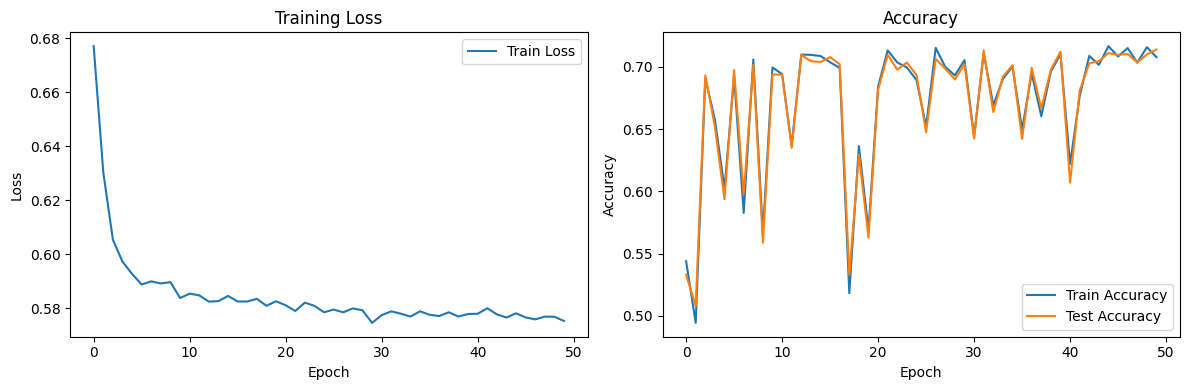

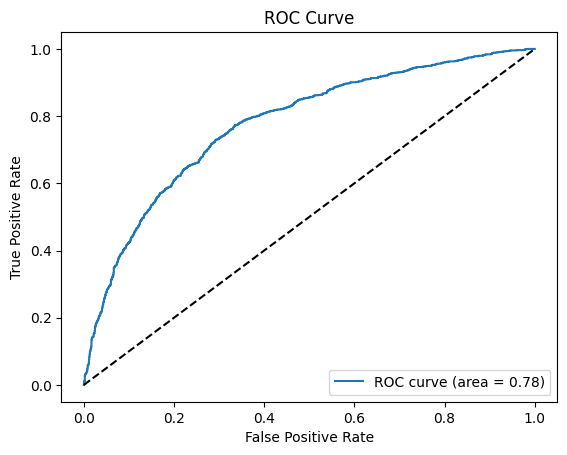

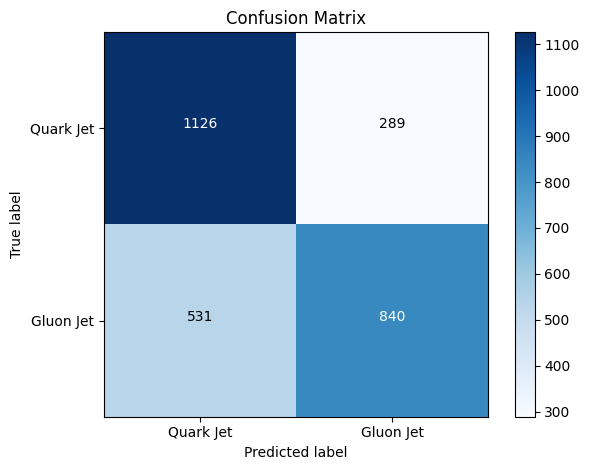

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import torch

# Create the target directory.
save_dir = "/content/drive/MyDrive/GSoC-GENIE/Common-Task-2"
os.makedirs(save_dir, exist_ok=True)

# Plotting training curves.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()

# Save training curves figure.
training_curve_path = os.path.join(save_dir, "training_curves.png")
plt.savefig(training_curve_path, dpi=300)
plt.show()

# Evaluate the model on the test set to compute ROC-AUC and confusion matrix.
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        all_preds.append(out.squeeze().cpu())
        all_targets.append(data.y.cpu())
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# ROC curve and AUC are computed.
fpr, tpr, thresholds = roc_curve(all_targets, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# Save ROC curve figure.
roc_curve_path = os.path.join(save_dir, "roc_curve.png")
plt.savefig(roc_curve_path, dpi=300)
plt.show()

# A confusion matrix is computed and displayed.
class_names = ['Quark Jet', 'Gluon Jet']
pred_labels = (all_preds > 0.5).astype(int)
cm = confusion_matrix(all_targets, pred_labels)

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()

# Save confusion matrix figure.
confusion_matrix_path = os.path.join(save_dir, "confusion_matrix.png")
plt.savefig(confusion_matrix_path, dpi=300)
plt.show()


---

# **Specific Task 1: Deep Graph Anomaly Detection with Contrastive Learning**

## **Best Model | Training**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/GSoC-GENIE/"

# ========== Setup and Installation ==========
import os
import torch
import numpy as np
import h5py
import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# Define directory paths.
my_dir = "/content/drive/MyDrive/GSoC-GENIE/"
data_path = os.path.join(my_dir, "data", "quark-gluon_data-set_n139306.hdf5")

# ========== Custom Graph Augmentations ==========
class EdgeRemoving:
    def __init__(self, pe):
        self.pe = pe

    def __call__(self, x, edge_index):
        # Randomly drop each edge with probability pe.
        num_edges = edge_index.shape[1]
        mask = torch.rand(num_edges, device=edge_index.device) > self.pe
        new_edge_index = edge_index[:, mask]
        return x, new_edge_index

class FeatureMasking:
    def __init__(self, pf):
        self.pf = pf

    def __call__(self, x, edge_index):
        # For each node, mask its features (set to 0) with probability pf.
        mask = (torch.rand(x.shape[0], device=x.device) >= self.pf).float().unsqueeze(1)
        new_x = x * mask
        return new_x, edge_index

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, edge_index):
        for transform in self.transforms:
            x, edge_index = transform(x, edge_index)
        return x, edge_index

# Instantiate the augmentation pipeline.
graph_aug = Compose([EdgeRemoving(pe=0.3), FeatureMasking(pf=0.3)])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Custom InfoNCE Loss ==========
class InfoNCELoss(nn.Module):
    def __init__(self, tau=0.2):
        super(InfoNCELoss, self).__init__()
        self.tau = tau
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z1, z2):
        # Normalize the projected embeddings.
        z1_norm = F.normalize(z1, p=2, dim=1)
        z2_norm = F.normalize(z2, p=2, dim=1)
        # Compute the cosine similarity matrix scaled by temperature.
        sim_matrix = torch.mm(z1_norm, z2_norm.t()) / self.tau
        batch_size = sim_matrix.size(0)
        labels = torch.arange(batch_size, device=z1.device)
        loss1 = self.criterion(sim_matrix, labels)
        loss2 = self.criterion(sim_matrix.t(), labels)
        loss = (loss1 + loss2) / 2
        return loss

contrast_loss = InfoNCELoss(tau=0.2).to(device)

# ========== Data Loading ==========
with h5py.File(data_path, 'r') as file:
    jets = np.array(file['X_jets'][:8000])
    jet_labels = np.array(file['y'][:8000])

# ========== Graph Construction ==========
graph_list = []
for idx, event in enumerate(jets):
    # Reshape image to (num_pixels, channels)
    event_flat = event.reshape(-1, 3)
    # Select non-zero pixels across all channels
    valid_pixels = np.any(event_flat != (0, 0, 0), axis=-1)
    node_features = event_flat[valid_pixels]
    # Create connectivity graph with 2 nearest neighbors
    conn_matrix = kneighbors_graph(node_features, n_neighbors=2, mode='connectivity', include_self=True)
    conn_matrix = conn_matrix.tocoo()
    label = torch.tensor([int(jet_labels[idx])], dtype=torch.long)
    graph_data = Data(
        x=torch.from_numpy(node_features).float(),
        edge_index=torch.from_numpy(
            np.vstack((conn_matrix.row, conn_matrix.col))
        ).long(),
        edge_attr=torch.from_numpy(conn_matrix.data.reshape(-1, 1)).float(),
        y=label
    )
    graph_list.append(graph_data)

print(f"Total graphs: {len(graph_list)}")
print(f"Nodes in first graph: {graph_list[0].num_nodes}")
print(f"Edges in first graph: {graph_list[0].num_edges}")
print(f"Node feature dimension: {graph_list[0].num_node_features}")
print(f"Edge feature dimension: {graph_list[0].num_edge_features}")

# ========== DataLoader Setup ==========
train_loader = DataLoader(graph_list[:5000], batch_size=8, shuffle=True)
test_loader = DataLoader(graph_list[5000:], batch_size=8, shuffle=False)

# ========== Model Definition: Graph Encoder ==========
class GraphEncoder(nn.Module):
    def __init__(self):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(3, 32)
        self.conv2 = GCNConv(32, 32)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 32)
        self.activation = nn.ReLU()

    def forward(self, data):
        # Generate two augmented graphs for contrastive branches.
        aug1_x, aug1_edge = graph_aug(data.x, data.edge_index)
        aug2_x, aug2_edge = graph_aug(data.x, data.edge_index)

        # Process first augmented graph.
        h1 = self.activation(self.conv1(aug1_x, aug1_edge))
        z1 = self.activation(self.conv2(h1, aug1_edge))

        # Process second augmented graph.
        h2 = self.activation(self.conv1(aug2_x, aug2_edge))
        z2 = self.activation(self.conv2(h2, aug2_edge))

        # Process original graph.
        h_orig = self.activation(self.conv1(data.x, data.edge_index))
        z_orig = self.activation(self.conv2(h_orig, data.edge_index))

        return z_orig, z1, z2

    def projection(self, embedding):
        proj_hidden = F.elu(self.fc1(embedding))
        return self.fc2(proj_hidden)

# ========== Training: Contrastive Learning ==========
def contrast_train_step(encoder, loss_fn, batch_data, optim):
    encoder.train()
    optim.zero_grad()
    emb_orig, emb_aug1, emb_aug2 = encoder(batch_data)
    proj1 = encoder.projection(emb_aug1)
    proj2 = encoder.projection(emb_aug2)
    loss = loss_fn(proj1, proj2)
    loss.backward()
    optim.step()
    return loss.item()

def contrast_eval_step(encoder, loss_fn, batch_data):
    encoder.eval()
    with torch.no_grad():
        emb_orig, emb_aug1, emb_aug2 = encoder(batch_data)
        proj1 = encoder.projection(emb_aug1)
        proj2 = encoder.projection(emb_aug2)
        loss = loss_fn(proj1, proj2)
    return loss.item()

# Instantiate encoder and optimizer for contrastive learning.
encoder_model = GraphEncoder().to(device)
optimizer_contrast = Adam(encoder_model.parameters(), lr=0.01)

# Contrastive training loop.
num_contrast_epochs = 30
for epoch in range(num_contrast_epochs):
    train_loss_epoch = 0
    for batch in tqdm.tqdm(train_loader, desc=f"Contrast Epoch {epoch+1}"):
        batch = batch.to(device)
        train_loss_epoch += contrast_train_step(encoder_model, contrast_loss, batch, optimizer_contrast)

    test_loss_epoch = 0
    for batch in tqdm.tqdm(test_loader, desc=f"Contrast Eval Epoch {epoch+1}"):
        batch = batch.to(device)
        test_loss_epoch += contrast_eval_step(encoder_model, contrast_loss, batch)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss_epoch/len(train_loader):.3f}, Test Loss = {test_loss_epoch/len(test_loader):.3f}")

# Save pretrained encoder weights.
torch.save(encoder_model.state_dict(), 'encoder_contrast_weights.pth')
print("Encoder weights saved.")

# ========== Model Definition: Graph Classification ==========
class JetClassifier(nn.Module):
    def __init__(self, freeze_encoder=True):
        super(JetClassifier, self).__init__()
        self.encoder = GraphEncoder().to(device)
        # Load pretrained weights.
        self.encoder.load_state_dict(torch.load('encoder_contrast_weights.pth'))
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.classifier = nn.Linear(32, 2)

    def forward(self, data):
        node_embeddings, _, _ = self.encoder(data)
        graph_embedding = global_mean_pool(node_embeddings, data.batch)
        return self.classifier(graph_embedding)

# ========== Training: Graph Classification ==========
def train_classifier(model, loader, optim_cls, loss_fn):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_samples = 0
    for batch in tqdm.tqdm(loader, desc="Classifier Training"):
        batch = batch.to(device)
        optim_cls.zero_grad()
        outputs = model(batch)
        loss = loss_fn(outputs, batch.y)
        loss.backward()
        optim_cls.step()
        total_loss += loss.item() * batch.num_graphs
        predictions = outputs.argmax(dim=1)
        correct_preds += (predictions == batch.y).sum().item()
        total_samples += batch.num_graphs
    return total_loss / total_samples, correct_preds / total_samples

def evaluate_classifier(model, loader):
    model.eval()
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            outputs = model(batch)
            predictions = outputs.argmax(dim=1)
            correct_preds += (predictions == batch.y).sum().item()
            total_samples += batch.num_graphs
    return correct_preds / total_samples

# Instantiate classifier, optimizer, and loss function for classification.
classifier_model = JetClassifier(freeze_encoder=True).to(device)
optimizer_cls = Adam(classifier_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Classification training loop.
num_cls_epochs = 20
for epoch in range(num_cls_epochs):
    train_loss, train_acc = train_classifier(classifier_model, train_loader, optimizer_cls, criterion)
    test_acc = evaluate_classifier(classifier_model, test_loader)
    print(f"Classifier Epoch {epoch+1}: Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total graphs: 8000
Nodes in first graph: 884
Edges in first graph: 1768
Node feature dimension: 3
Edge feature dimension: 1


Contrast Eval Epoch 1: 100%|██████████| 375/375 [00:05<00:00, 72.02it/s]


Epoch 1: Train Loss = 7.977, Test Loss = 7.754


Contrast Eval Epoch 2: 100%|██████████| 375/375 [00:05<00:00, 69.96it/s]


Epoch 2: Train Loss = 7.641, Test Loss = 7.559


Contrast Eval Epoch 3: 100%|██████████| 375/375 [00:04<00:00, 75.42it/s]


Epoch 3: Train Loss = 7.515, Test Loss = 7.410


Contrast Eval Epoch 4: 100%|██████████| 375/375 [00:05<00:00, 68.73it/s]


Epoch 4: Train Loss = 7.419, Test Loss = 7.387


Contrast Eval Epoch 5: 100%|██████████| 375/375 [00:05<00:00, 73.26it/s]


Epoch 5: Train Loss = 7.345, Test Loss = 7.280


Contrast Eval Epoch 6: 100%|██████████| 375/375 [00:05<00:00, 68.18it/s]


Epoch 6: Train Loss = 7.302, Test Loss = 7.291


Contrast Eval Epoch 7: 100%|██████████| 375/375 [00:05<00:00, 74.98it/s]


Epoch 7: Train Loss = 7.241, Test Loss = 7.213


Contrast Eval Epoch 8: 100%|██████████| 375/375 [00:05<00:00, 62.53it/s]


Epoch 8: Train Loss = 7.187, Test Loss = 7.285


Contrast Eval Epoch 9: 100%|██████████| 375/375 [00:05<00:00, 71.31it/s]


Epoch 9: Train Loss = 7.157, Test Loss = 7.113


Contrast Eval Epoch 10: 100%|██████████| 375/375 [00:04<00:00, 75.63it/s]


Epoch 10: Train Loss = 7.134, Test Loss = 7.048


Contrast Eval Epoch 11: 100%|██████████| 375/375 [00:05<00:00, 67.58it/s]


Epoch 11: Train Loss = 7.108, Test Loss = 7.070


Contrast Eval Epoch 12: 100%|██████████| 375/375 [00:04<00:00, 75.21it/s]


Epoch 12: Train Loss = 7.088, Test Loss = 7.047


Contrast Eval Epoch 13: 100%|██████████| 375/375 [00:05<00:00, 71.67it/s]


Epoch 13: Train Loss = 7.069, Test Loss = 7.095


Contrast Eval Epoch 14: 100%|██████████| 375/375 [00:05<00:00, 73.36it/s]


Epoch 14: Train Loss = 7.050, Test Loss = 7.029


Contrast Eval Epoch 15: 100%|██████████| 375/375 [00:04<00:00, 75.77it/s]


Epoch 15: Train Loss = 7.032, Test Loss = 6.981


Contrast Eval Epoch 16: 100%|██████████| 375/375 [00:05<00:00, 69.51it/s]


Epoch 16: Train Loss = 7.030, Test Loss = 7.051


Contrast Eval Epoch 17: 100%|██████████| 375/375 [00:04<00:00, 75.38it/s]


Epoch 17: Train Loss = 7.015, Test Loss = 7.006


Contrast Eval Epoch 18: 100%|██████████| 375/375 [00:05<00:00, 68.51it/s]


Epoch 18: Train Loss = 7.017, Test Loss = 7.045


Contrast Eval Epoch 19: 100%|██████████| 375/375 [00:04<00:00, 76.09it/s]


Epoch 19: Train Loss = 6.996, Test Loss = 7.063


Contrast Eval Epoch 20: 100%|██████████| 375/375 [00:05<00:00, 69.28it/s]


Epoch 20: Train Loss = 7.090, Test Loss = 7.192


Contrast Eval Epoch 21: 100%|██████████| 375/375 [00:04<00:00, 75.15it/s]


Epoch 21: Train Loss = 7.101, Test Loss = 7.024


Contrast Eval Epoch 22: 100%|██████████| 375/375 [00:05<00:00, 72.55it/s]


Epoch 22: Train Loss = 7.022, Test Loss = 6.995


Contrast Eval Epoch 23: 100%|██████████| 375/375 [00:05<00:00, 73.40it/s]


Epoch 23: Train Loss = 6.985, Test Loss = 6.994


Contrast Eval Epoch 24: 100%|██████████| 375/375 [00:04<00:00, 75.90it/s]


Epoch 24: Train Loss = 6.970, Test Loss = 6.967


Contrast Eval Epoch 25: 100%|██████████| 375/375 [00:05<00:00, 70.84it/s]


Epoch 25: Train Loss = 6.944, Test Loss = 6.984


Contrast Eval Epoch 26: 100%|██████████| 375/375 [00:04<00:00, 76.06it/s]


Epoch 26: Train Loss = 6.942, Test Loss = 6.961


Contrast Eval Epoch 27: 100%|██████████| 375/375 [00:05<00:00, 69.13it/s]


Epoch 27: Train Loss = 6.940, Test Loss = 6.927


Contrast Eval Epoch 28: 100%|██████████| 375/375 [00:04<00:00, 76.47it/s]


Epoch 28: Train Loss = 6.917, Test Loss = 6.919


Contrast Eval Epoch 29: 100%|██████████| 375/375 [00:05<00:00, 69.36it/s]


Epoch 29: Train Loss = 6.925, Test Loss = 6.934


Contrast Eval Epoch 30: 100%|██████████| 375/375 [00:04<00:00, 75.31it/s]


Epoch 30: Train Loss = 6.907, Test Loss = 6.935
Encoder weights saved.


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 114.53it/s]


Classifier Epoch 1: Loss = 0.6529, Train Acc = 0.6298, Test Acc = 0.6417


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.57it/s]


Classifier Epoch 2: Loss = 0.6377, Train Acc = 0.6624, Test Acc = 0.6747


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 121.71it/s]


Classifier Epoch 3: Loss = 0.6389, Train Acc = 0.6508, Test Acc = 0.6823


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 132.90it/s]


Classifier Epoch 4: Loss = 0.6324, Train Acc = 0.6672, Test Acc = 0.6837


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 135.31it/s]


Classifier Epoch 5: Loss = 0.6326, Train Acc = 0.6660, Test Acc = 0.6853


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 118.12it/s]


Classifier Epoch 6: Loss = 0.6325, Train Acc = 0.6670, Test Acc = 0.6850


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.01it/s]


Classifier Epoch 7: Loss = 0.6264, Train Acc = 0.6672, Test Acc = 0.6767


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 113.77it/s]


Classifier Epoch 8: Loss = 0.6303, Train Acc = 0.6718, Test Acc = 0.6947


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 132.80it/s]


Classifier Epoch 9: Loss = 0.6267, Train Acc = 0.6732, Test Acc = 0.6503


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 124.51it/s]


Classifier Epoch 10: Loss = 0.6254, Train Acc = 0.6734, Test Acc = 0.6833


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 132.28it/s]


Classifier Epoch 11: Loss = 0.6224, Train Acc = 0.6712, Test Acc = 0.6920


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 136.51it/s]


Classifier Epoch 12: Loss = 0.6254, Train Acc = 0.6742, Test Acc = 0.6900


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 116.87it/s]


Classifier Epoch 13: Loss = 0.6255, Train Acc = 0.6672, Test Acc = 0.6923


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.65it/s]


Classifier Epoch 14: Loss = 0.6314, Train Acc = 0.6716, Test Acc = 0.6947


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 116.42it/s]


Classifier Epoch 15: Loss = 0.6205, Train Acc = 0.6802, Test Acc = 0.6743


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 135.48it/s]


Classifier Epoch 16: Loss = 0.6226, Train Acc = 0.6746, Test Acc = 0.6947


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 121.48it/s]


Classifier Epoch 17: Loss = 0.6260, Train Acc = 0.6742, Test Acc = 0.6737


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 131.51it/s]


Classifier Epoch 18: Loss = 0.6287, Train Acc = 0.6750, Test Acc = 0.6807


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 135.22it/s]


Classifier Epoch 19: Loss = 0.6171, Train Acc = 0.6798, Test Acc = 0.6853


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 117.14it/s]


Classifier Epoch 20: Loss = 0.6219, Train Acc = 0.6754, Test Acc = 0.6453


## **Evaluation**

Classifier Training: 100%|██████████| 625/625 [00:08<00:00, 76.43it/s]


Classifier Epoch 1: Loss = 0.6207, Train Acc = 0.6774, Test Acc = 0.6900


Classifier Training: 100%|██████████| 625/625 [00:09<00:00, 63.23it/s]


Classifier Epoch 2: Loss = 0.6257, Train Acc = 0.6772, Test Acc = 0.6917


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.27it/s]


Classifier Epoch 3: Loss = 0.6188, Train Acc = 0.6784, Test Acc = 0.6900


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 122.64it/s]


Classifier Epoch 4: Loss = 0.6172, Train Acc = 0.6866, Test Acc = 0.7017


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 131.43it/s]


Classifier Epoch 5: Loss = 0.6156, Train Acc = 0.6916, Test Acc = 0.6493


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 132.62it/s]


Classifier Epoch 6: Loss = 0.6165, Train Acc = 0.6838, Test Acc = 0.6843


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 117.33it/s]


Classifier Epoch 7: Loss = 0.6215, Train Acc = 0.6780, Test Acc = 0.6893


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 135.12it/s]


Classifier Epoch 8: Loss = 0.6170, Train Acc = 0.6852, Test Acc = 0.6810


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 115.92it/s]


Classifier Epoch 9: Loss = 0.6149, Train Acc = 0.6768, Test Acc = 0.7080


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.26it/s]


Classifier Epoch 10: Loss = 0.6147, Train Acc = 0.6794, Test Acc = 0.7050


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 123.58it/s]


Classifier Epoch 11: Loss = 0.6189, Train Acc = 0.6844, Test Acc = 0.7067


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 130.64it/s]


Classifier Epoch 12: Loss = 0.6236, Train Acc = 0.6806, Test Acc = 0.6853


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.35it/s]


Classifier Epoch 13: Loss = 0.6187, Train Acc = 0.6870, Test Acc = 0.6197


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 114.29it/s]


Classifier Epoch 14: Loss = 0.6187, Train Acc = 0.6774, Test Acc = 0.7020


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 135.31it/s]


Classifier Epoch 15: Loss = 0.6301, Train Acc = 0.6778, Test Acc = 0.6880


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 116.73it/s]


Classifier Epoch 16: Loss = 0.6208, Train Acc = 0.6812, Test Acc = 0.6403


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 132.01it/s]


Classifier Epoch 17: Loss = 0.6147, Train Acc = 0.6930, Test Acc = 0.6360


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 129.99it/s]


Classifier Epoch 18: Loss = 0.6176, Train Acc = 0.6852, Test Acc = 0.6973


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 124.41it/s]


Classifier Epoch 19: Loss = 0.6150, Train Acc = 0.6782, Test Acc = 0.6617


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 113.95it/s]


Classifier Epoch 20: Loss = 0.6167, Train Acc = 0.6794, Test Acc = 0.7060


Classifier Training: 100%|██████████| 625/625 [00:09<00:00, 68.51it/s]


Classifier Epoch 21: Loss = 0.6144, Train Acc = 0.6842, Test Acc = 0.7067


Classifier Training: 100%|██████████| 625/625 [00:09<00:00, 68.96it/s]


Classifier Epoch 22: Loss = 0.6215, Train Acc = 0.6776, Test Acc = 0.6993


Classifier Training: 100%|██████████| 625/625 [00:08<00:00, 77.29it/s]


Classifier Epoch 23: Loss = 0.6130, Train Acc = 0.6896, Test Acc = 0.6847


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 111.45it/s]


Classifier Epoch 24: Loss = 0.6144, Train Acc = 0.6830, Test Acc = 0.6667


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.86it/s]


Classifier Epoch 25: Loss = 0.6162, Train Acc = 0.6808, Test Acc = 0.6913


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 116.44it/s]


Classifier Epoch 26: Loss = 0.6114, Train Acc = 0.6896, Test Acc = 0.5210


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.86it/s]


Classifier Epoch 27: Loss = 0.6175, Train Acc = 0.6786, Test Acc = 0.6813


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 123.00it/s]


Classifier Epoch 28: Loss = 0.6170, Train Acc = 0.6842, Test Acc = 0.7077


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 128.79it/s]


Classifier Epoch 29: Loss = 0.6177, Train Acc = 0.6860, Test Acc = 0.7067


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.78it/s]


Classifier Epoch 30: Loss = 0.6226, Train Acc = 0.6722, Test Acc = 0.6757


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 116.10it/s]


Classifier Epoch 31: Loss = 0.6206, Train Acc = 0.6840, Test Acc = 0.7060


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 133.71it/s]


Classifier Epoch 32: Loss = 0.6147, Train Acc = 0.6842, Test Acc = 0.6813


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 116.38it/s]


Classifier Epoch 33: Loss = 0.6157, Train Acc = 0.6824, Test Acc = 0.6927


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.63it/s]


Classifier Epoch 34: Loss = 0.6161, Train Acc = 0.6866, Test Acc = 0.6573


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 124.37it/s]


Classifier Epoch 35: Loss = 0.6124, Train Acc = 0.6910, Test Acc = 0.5123


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 115.14it/s]


Classifier Epoch 36: Loss = 0.6208, Train Acc = 0.6834, Test Acc = 0.6983


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 132.78it/s]


Classifier Epoch 37: Loss = 0.6200, Train Acc = 0.6858, Test Acc = 0.6747


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 115.08it/s]


Classifier Epoch 38: Loss = 0.6180, Train Acc = 0.6838, Test Acc = 0.7080


Classifier Training: 100%|██████████| 625/625 [00:06<00:00, 102.14it/s]


Classifier Epoch 39: Loss = 0.6124, Train Acc = 0.6856, Test Acc = 0.6713


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 133.52it/s]


Classifier Epoch 40: Loss = 0.6172, Train Acc = 0.6860, Test Acc = 0.6663


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 121.31it/s]


Classifier Epoch 41: Loss = 0.6139, Train Acc = 0.6876, Test Acc = 0.6803


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 133.44it/s]


Classifier Epoch 42: Loss = 0.6171, Train Acc = 0.6780, Test Acc = 0.7013


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 115.79it/s]


Classifier Epoch 43: Loss = 0.6100, Train Acc = 0.6862, Test Acc = 0.7063


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.10it/s]


Classifier Epoch 44: Loss = 0.6154, Train Acc = 0.6840, Test Acc = 0.7017


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 120.89it/s]


Classifier Epoch 45: Loss = 0.6178, Train Acc = 0.6818, Test Acc = 0.6813


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 131.11it/s]


Classifier Epoch 46: Loss = 0.6154, Train Acc = 0.6876, Test Acc = 0.7017


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 134.52it/s]


Classifier Epoch 47: Loss = 0.6241, Train Acc = 0.6824, Test Acc = 0.7030


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 115.22it/s]


Classifier Epoch 48: Loss = 0.6209, Train Acc = 0.6856, Test Acc = 0.6350


Classifier Training: 100%|██████████| 625/625 [00:04<00:00, 135.16it/s]


Classifier Epoch 49: Loss = 0.6189, Train Acc = 0.6786, Test Acc = 0.7053


Classifier Training: 100%|██████████| 625/625 [00:05<00:00, 116.43it/s]


Classifier Epoch 50: Loss = 0.6103, Train Acc = 0.6918, Test Acc = 0.7097


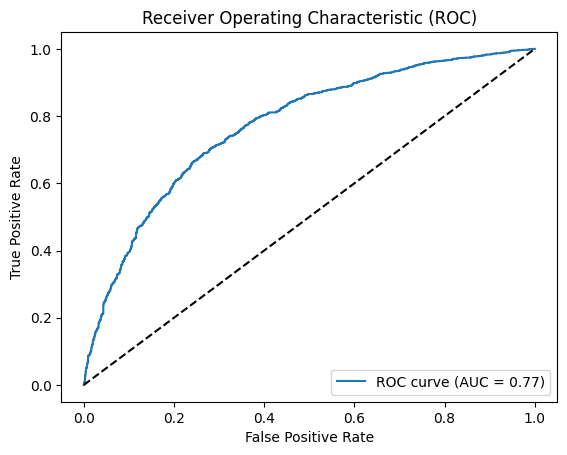

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

# Lists to store metrics per epoch.
train_losses = []
train_accuracies = []
test_accuracies = []

# Classification training loop with metric logging.
num_cls_epochs = 50
for epoch in range(num_cls_epochs):
    train_loss, train_acc = train_classifier(classifier_model, train_loader, optimizer_cls, criterion)
    test_acc = evaluate_classifier(classifier_model, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Classifier Epoch {epoch+1}: Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

# # Plot Loss Curve.
# plt.figure()
# plt.plot(range(1, num_cls_epochs+1), train_losses, marker='o', label='Train Loss')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training Loss")
# plt.legend()
# plt.show()

# # Plot Accuracy Curve.
# plt.figure()
# plt.plot(range(1, num_cls_epochs+1), train_accuracies, marker='o', label='Train Accuracy')
# plt.plot(range(1, num_cls_epochs+1), test_accuracies, marker='o', label='Test Accuracy')
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Accuracy Curve")
# plt.legend()
# plt.show()

# Compute ROC curve on the test set.
all_labels = []
all_probs = []
classifier_model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = classifier_model(batch)
        # Softmax is applied to obtain probabilities.
        probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # probability of class 1
        labels = batch.y.cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels)

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC AUC Curve.
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


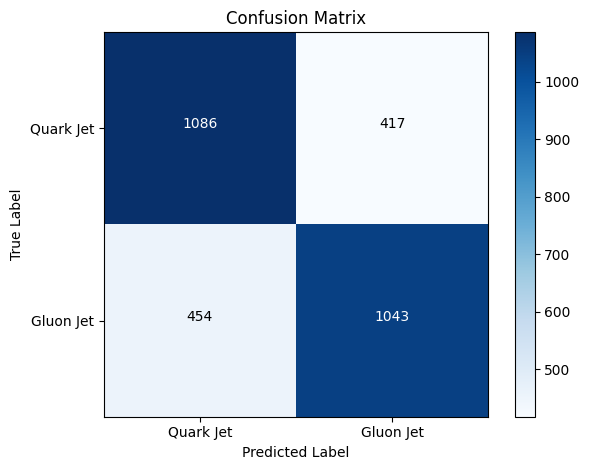

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Define class names corresponding to the labels.
class_names = ['Quark Jet', 'Gluon Jet']

# Gather predictions and true labels from the test set.
all_preds = []
all_labels = []
classifier_model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = classifier_model(batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Compute confusion matrix.
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix.
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [ ]:
total_subsamples = len(all_labels)
total_samples = len(graph_list)
with h5py.File(data_path, 'r') as file:
    total_labels = file['y'].shape[0]

total_subsamples, total_samples, total_labels

(7000, 12000, 139306)

---

# **Specific Task 2: Learning Parametrization with Implicit Neural Representations**

**Not successful so far. Needs more revision, but included here to display the method attempted.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/GSoC-GENIE/"

Mounted at /content/drive


In [ ]:
# ==== Import Libraries ====
import os
import json
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# ==== Directory Paths ====
my_dir = "/content/drive/MyDrive/GSoC-GENIE/"
data_path = os.path.join(my_dir, "data", "quark-gluon_data-set_n139306.hdf5")

# ==== Data Loading, Normalization, and Downsampling ====
with h5py.File(data_path, 'r') as f:
    total_samples = f['X_jets'].shape[0]
    print("Total samples in dataset:", total_samples)
    # Use a subsample (5% of total samples)
    n_samples = int(0.05 * total_samples)
    print("Using subsample of", n_samples, "samples.")
    X = f['X_jets'][:n_samples]

# Normalize each image; division by the maximum ensures values between 0 and 1
X_norm = np.array([img / np.max(img) if np.max(img) > 0 else img for img in X])
print("Normalized dataset shape:", X_norm.shape)

# Further downsample images for training (using 32x32 instead of 125x125)
downsampled_size = (32, 32)
X_down = tf.image.resize(X_norm, downsampled_size).numpy()
print("Downsampled dataset shape:", X_down.shape)

# ==== Data Splitting ====
split = int(0.8 * X_down.shape[0])
X_train = X_down[:split]
X_test = X_down[split:]
print("Training samples:", X_train.shape[0], "Testing samples:", X_test.shape[0])

# ==== Helper Function: Generate Normalized Coordinate Grid ====
def get_coordinate_grid(height, width):
    # Generate a coordinate grid with values in the range [-1, 1]
    xs = np.linspace(-1, 1, width)
    ys = np.linspace(-1, 1, height)
    xv, yv = np.meshgrid(xs, ys)
    coords = np.stack([xv, yv], axis=-1)  # Shape: (height, width, 2)
    return coords.astype(np.float32)

# ==== Encoder Model Definition ====
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim)(x)
    return models.Model(inputs, latent, name='encoder')

# ==== Custom Sinusoidal Activation Layer ====
class Sine(layers.Layer):
    def __init__(self, omega0=30, **kwargs):
        super(Sine, self).__init__(**kwargs)
        self.omega0 = omega0

    def call(self, inputs):
        return tf.math.sin(self.omega0 * inputs)

# ==== INR Decoder Definition ====
def build_inr_decoder(latent_dim, hidden_units=128, hidden_layers=2, output_channels=3):
    # The input shape is specified as a tuple: (2 + latent_dim,)
    inputs = layers.Input(shape=(2 + latent_dim,))
    x = layers.Dense(hidden_units)(inputs)
    x = Sine()(x)
    for _ in range(hidden_layers):
        x = layers.Dense(hidden_units)(x)
        x = Sine()(x)
    outputs = layers.Dense(output_channels, activation='sigmoid')(x)
    return models.Model(inputs, outputs, name='inr_decoder')

# ==== Custom Model: Combining Encoder and INR Decoder ====
class INRModel(tf.keras.Model):
    def __init__(self, encoder, decoder, height, width):
        super(INRModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.height = height
        self.width = width
        # Precompute the coordinate grid and reshape it to (height * width, 2)
        coords = get_coordinate_grid(height, width)
        self.coords = tf.constant(coords.reshape(-1, 2))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        latent = self.encoder(inputs)
        latent_expanded = tf.expand_dims(latent, axis=1)
        latent_tiled = tf.tile(latent_expanded, [1, tf.shape(self.coords)[0], 1])
        coords_tiled = tf.expand_dims(self.coords, axis=0)
        coords_tiled = tf.tile(coords_tiled, [batch_size, 1, 1])
        decoder_input = tf.concat([coords_tiled, latent_tiled], axis=-1)
        decoder_input_reshaped = tf.reshape(decoder_input, [-1, decoder_input.shape[-1]])
        out = self.decoder(decoder_input_reshaped)
        out = tf.reshape(out, [batch_size, self.height, self.width, -1])
        return out

# ==== Model Configuration and Construction ====
# Use the downsampled size for training
input_shape = (downsampled_size[0], downsampled_size[1], 3)
latent_dim = 64
height, width = downsampled_size

encoder = build_encoder(input_shape, latent_dim)
decoder = build_inr_decoder(latent_dim, hidden_units=128, hidden_layers=2, output_channels=3)
inr_model = INRModel(encoder, decoder, height, width)
inr_model.compile(optimizer='adam', loss='binary_crossentropy')

# ==== Model Training ====
history = inr_model.fit(X_train, X_train,
                        epochs=10,
                        batch_size=8,
                        shuffle=True,
                        validation_data=(X_test, X_test))


Total samples in dataset: 139306
Using subsample of 6965 samples.
Normalized dataset shape: (6965, 125, 125, 3)
Downsampled dataset shape: (6965, 32, 32, 3)
Training samples: 5572 Testing samples: 1393
Epoch 1/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 76s 103ms/step - loss: 0.6451 - val_loss: 0.4233
Epoch 2/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 68s 83ms/step - loss: 0.3785 - val_loss: 0.2682
Epoch 3/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - loss: 0.2421 - val_loss: 0.1771
Epoch 4/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 79s 81ms/step - loss: 0.1612 - val_loss: 0.1210
Epoch 5/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 93s 96ms/step - loss: 0.1109 - val_loss: 0.0850
Epoch 6/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - loss: 0.0783 - val_loss: 0.0609
Epoch 7/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - loss: 0.0563 - val_loss: 0.0443
Epoch 8/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - loss: 0.0411 - val_loss: 0.0327
Epoch 9/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 88s 90ms/step - loss: 0.0304 - val_loss: 0.0244
Epoch

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


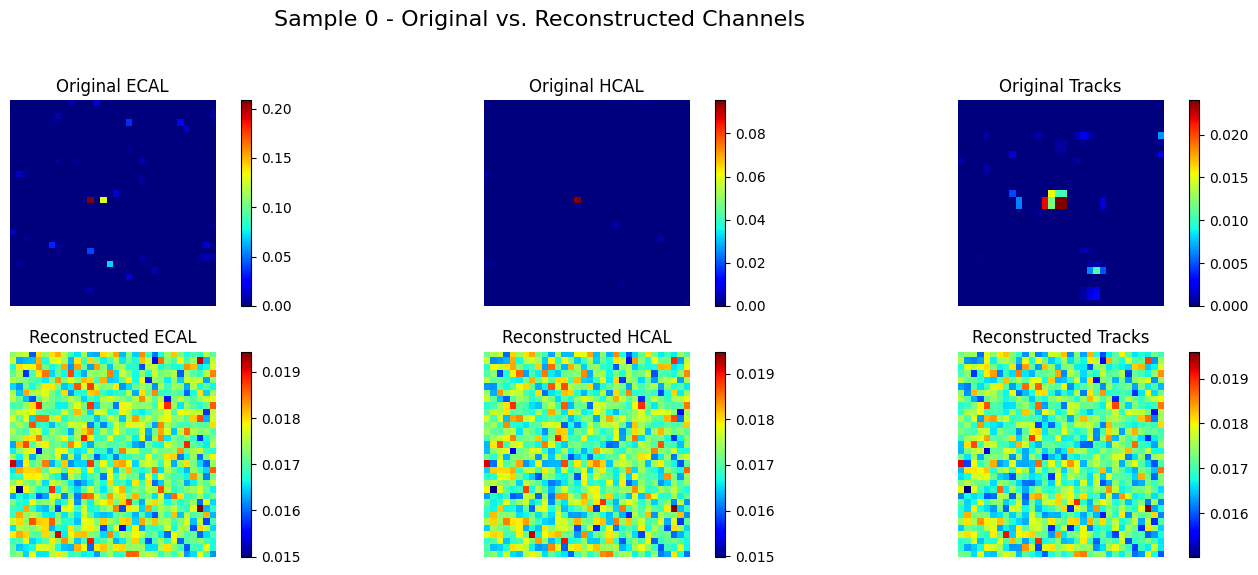

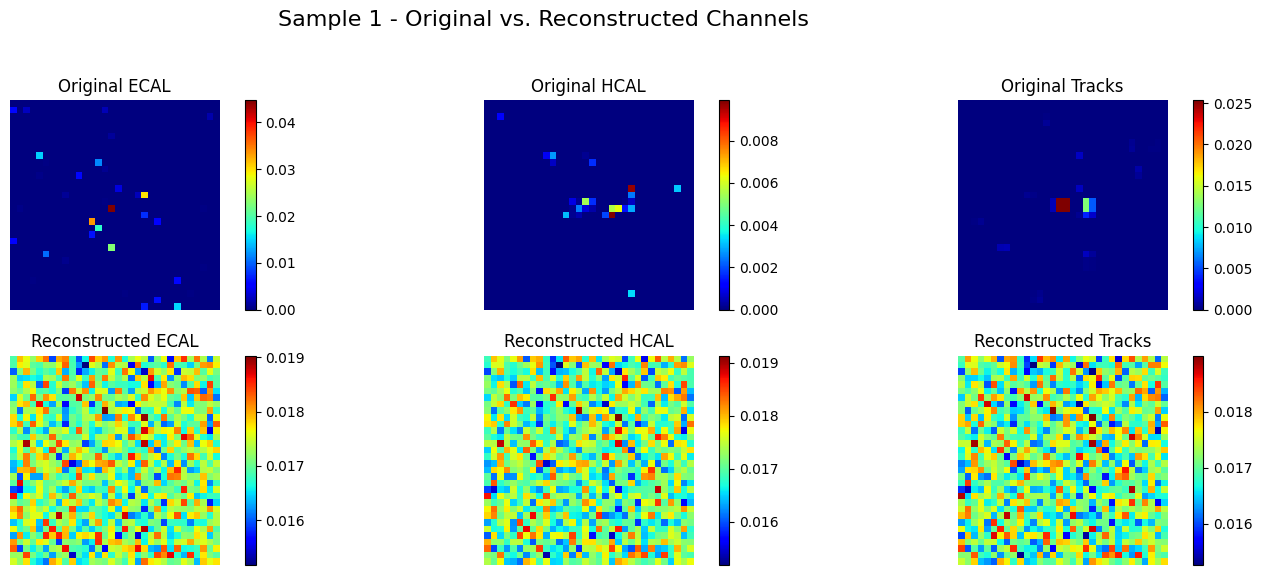

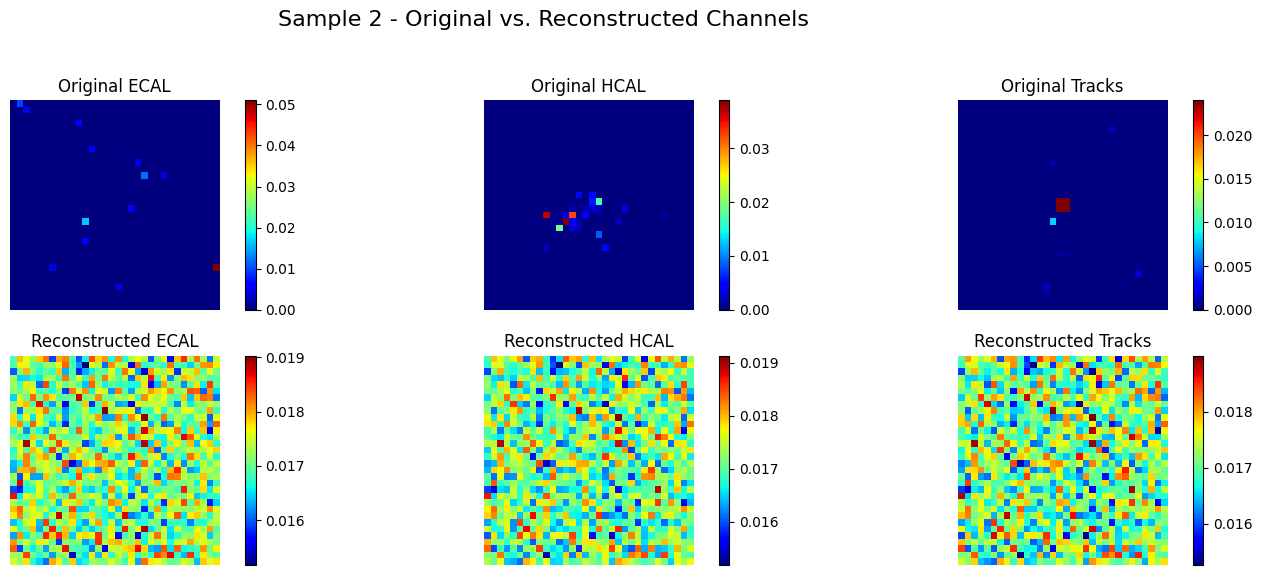

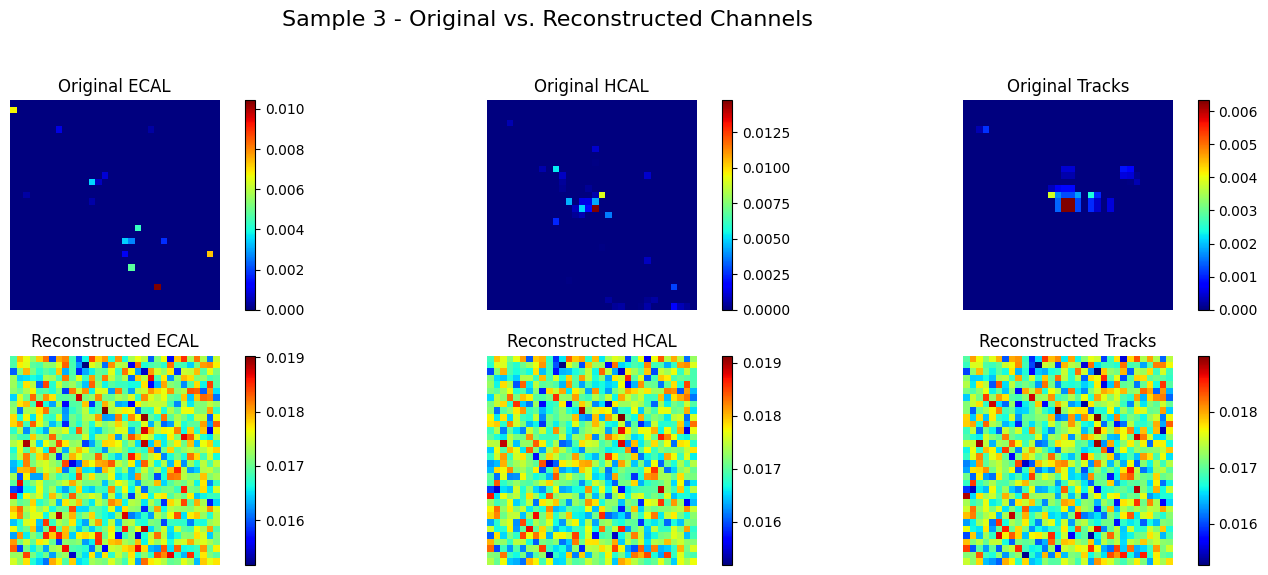

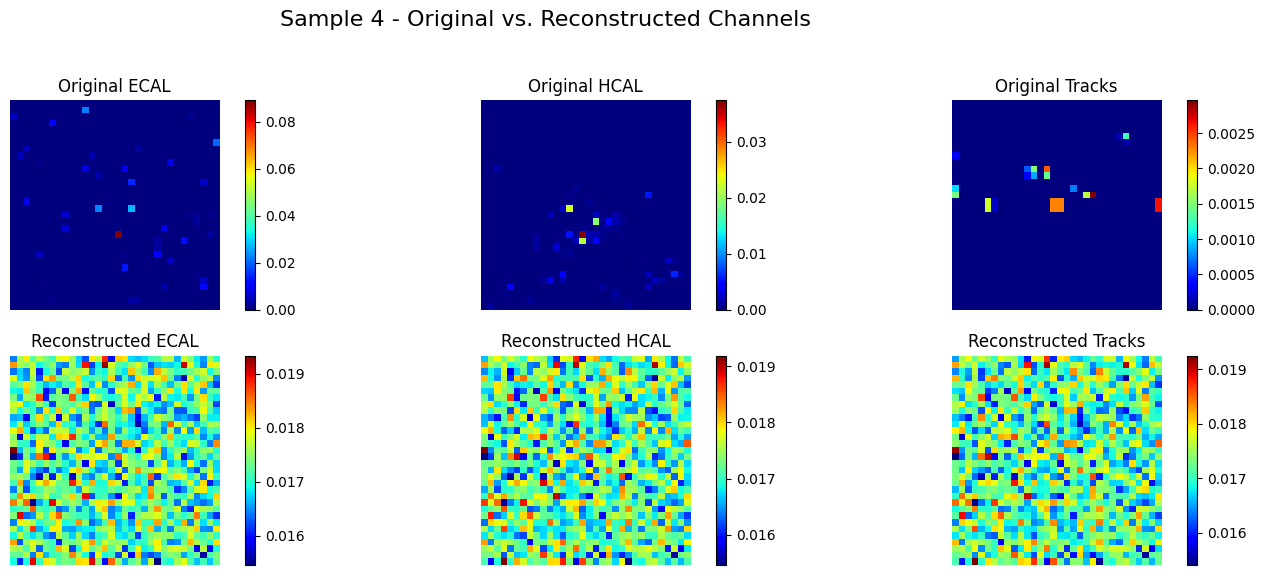

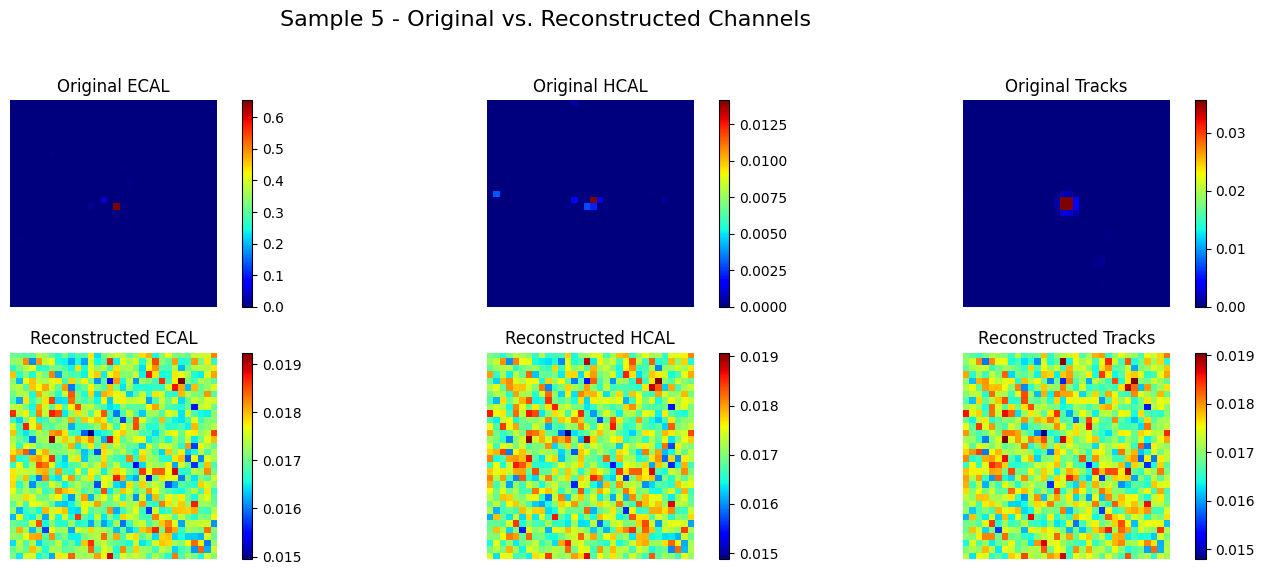

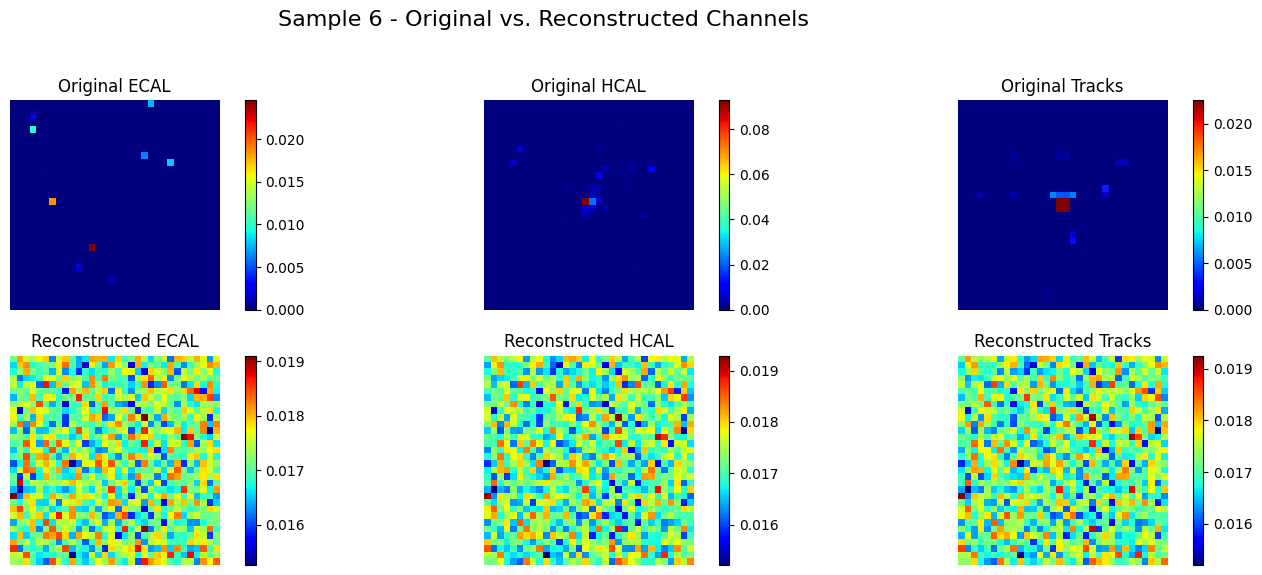

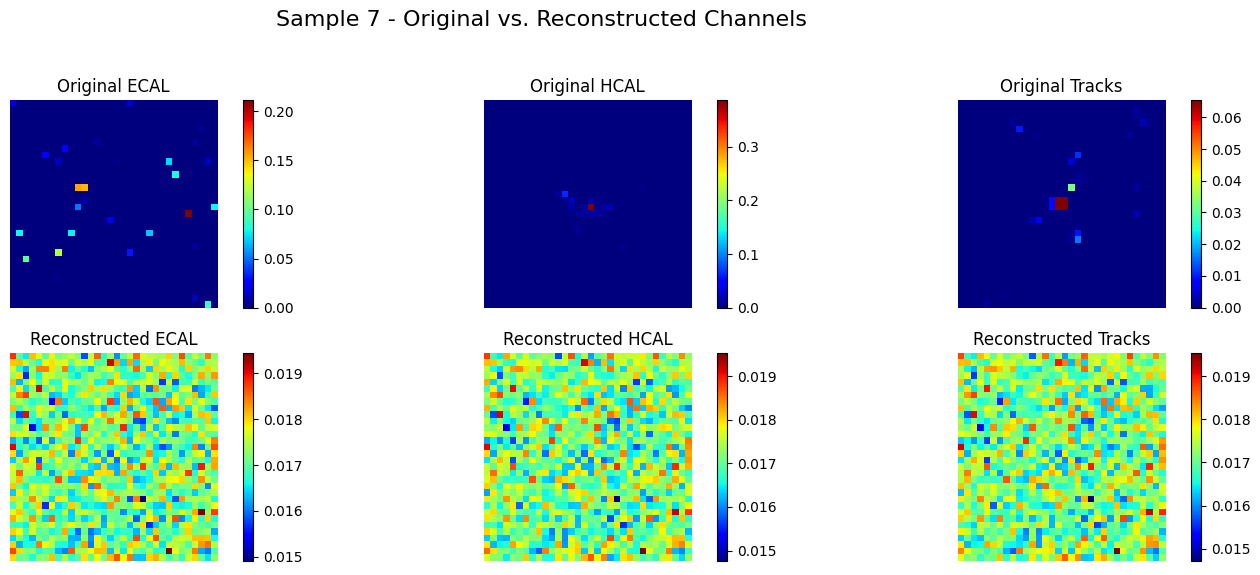

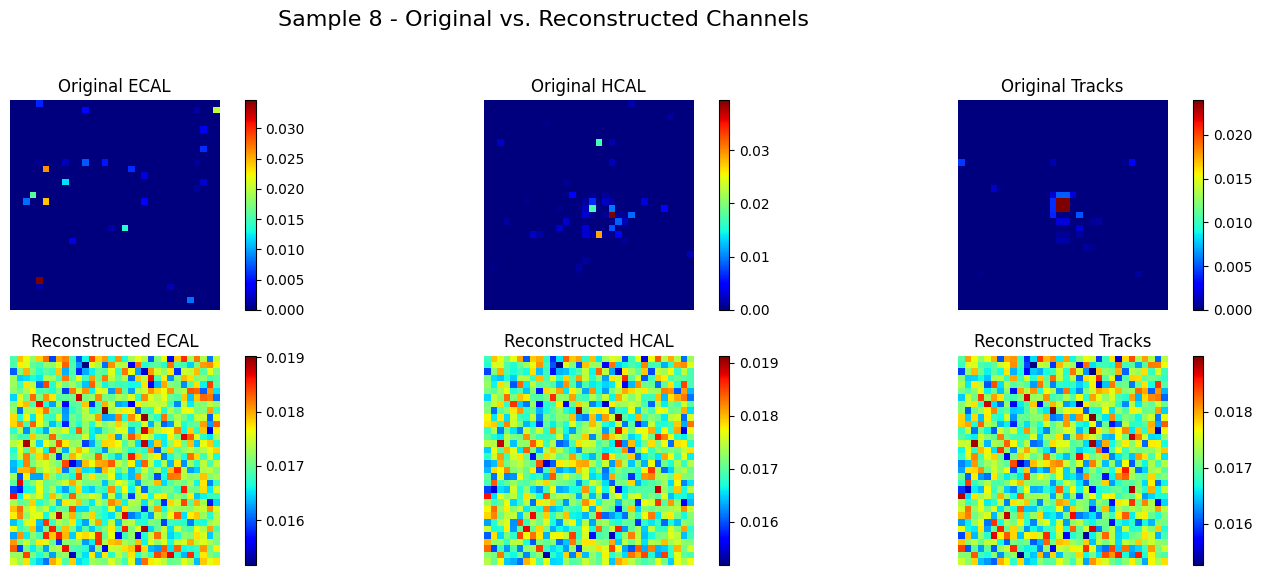

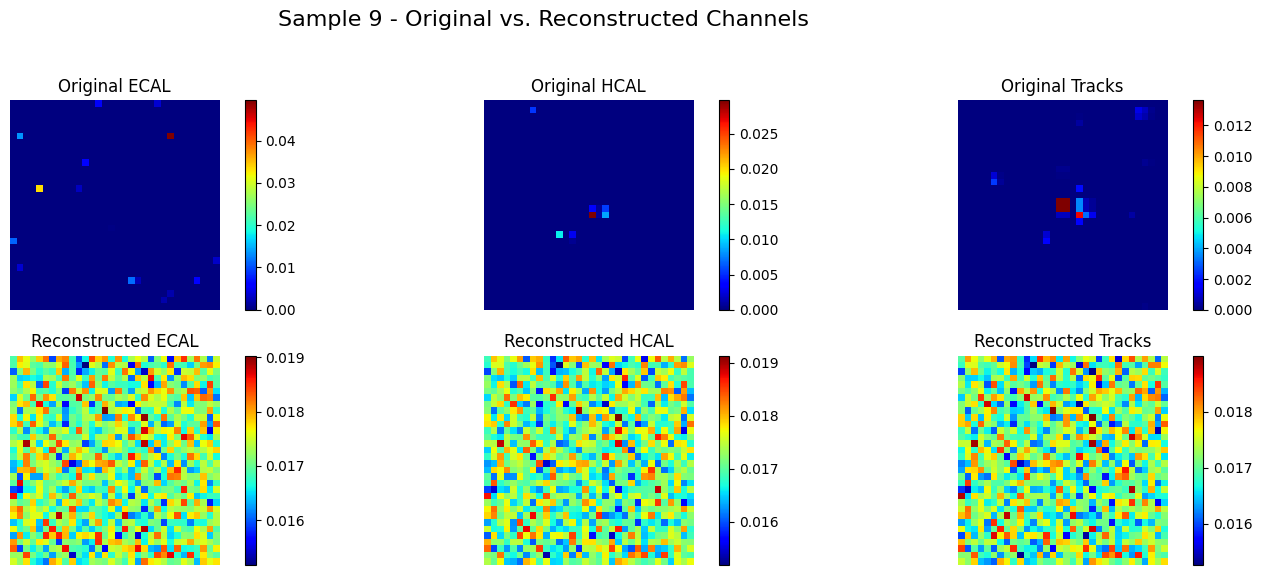

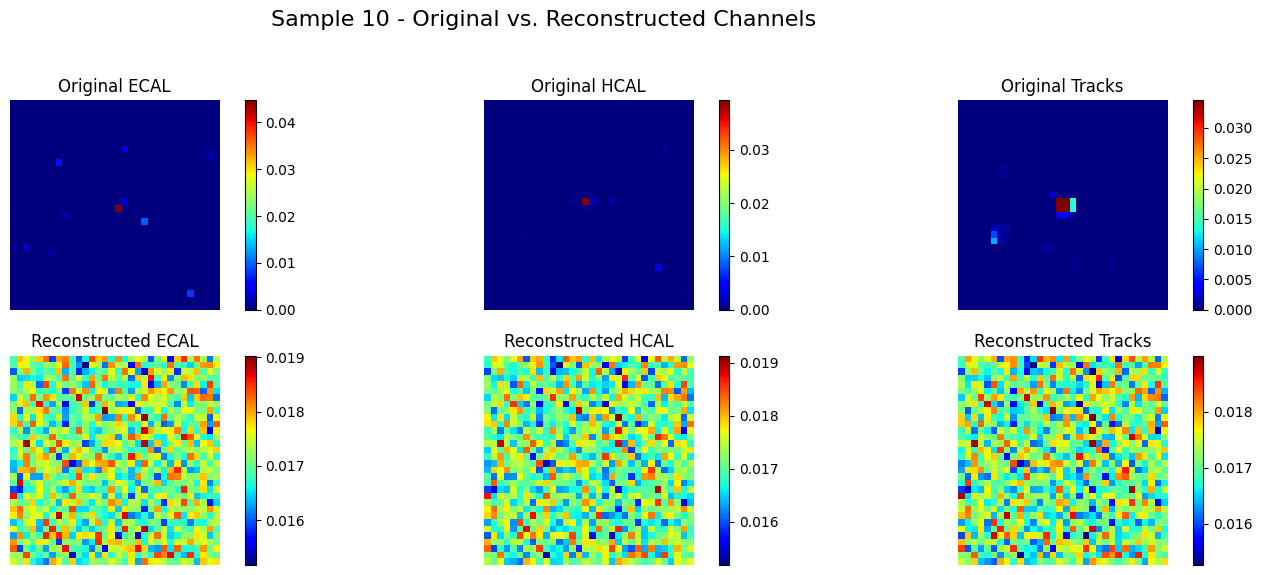

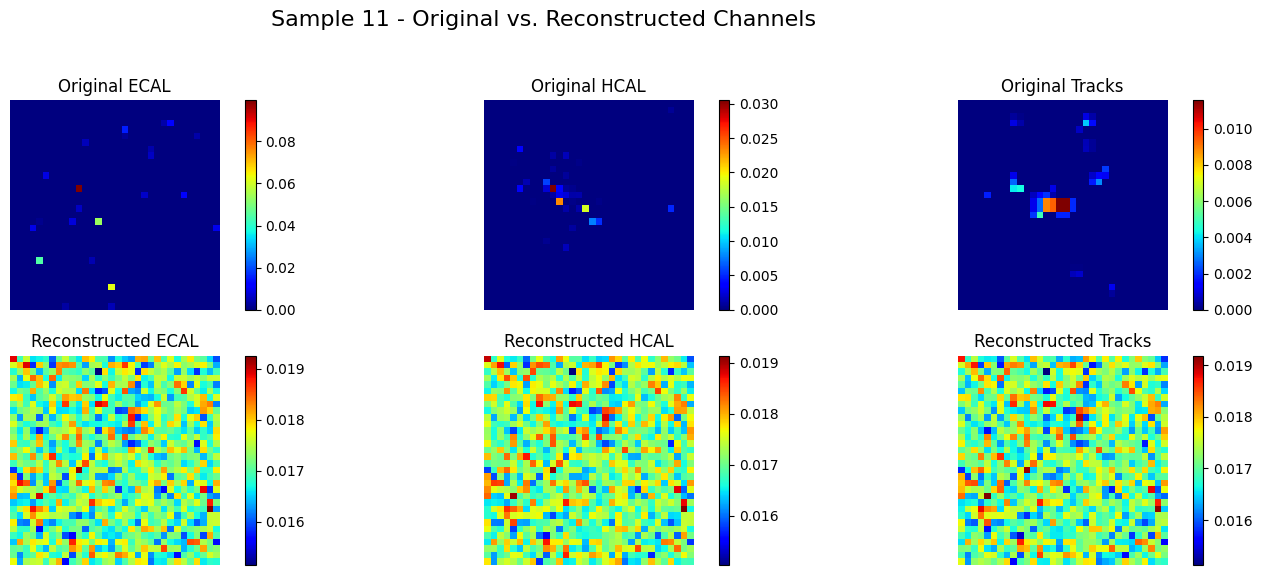

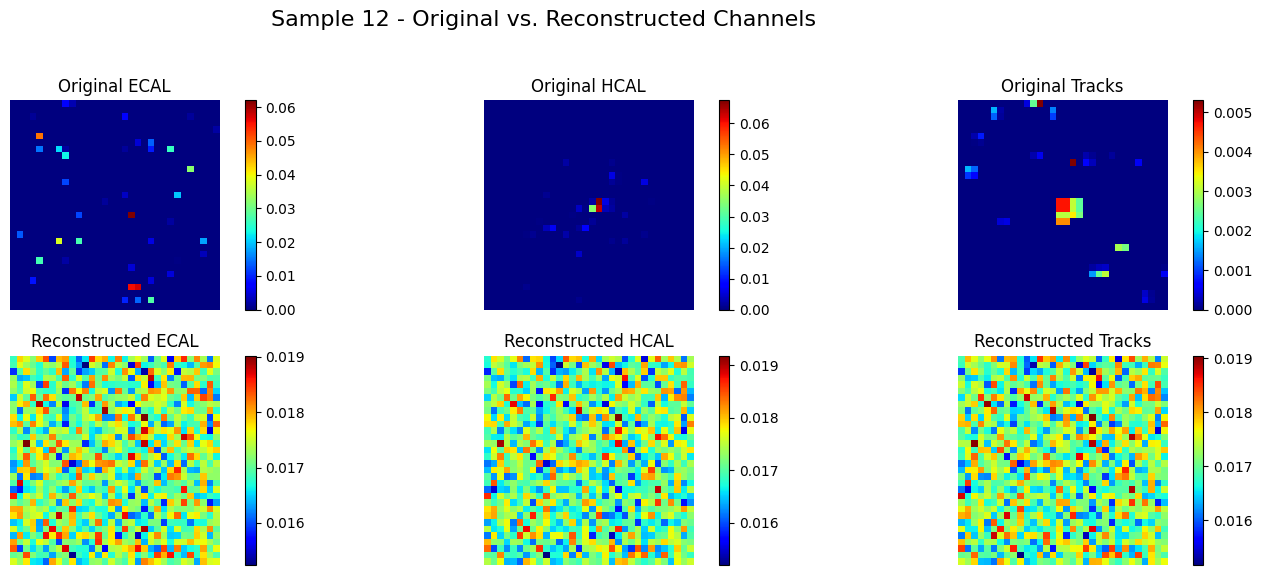

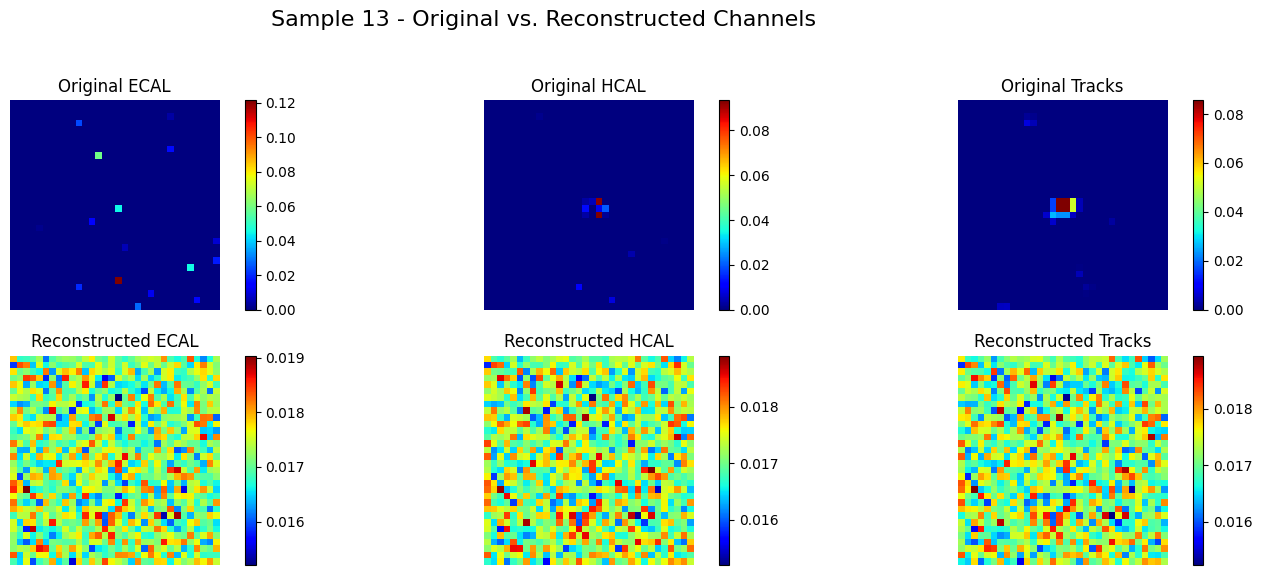

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Generate reconstructions for a small test batch using the INR model
reconstructed = inr_model.predict(X_test[:15])

# Define channel names
channels = ["ECAL", "HCAL", "Tracks"]
num_examples = 14  # Number of examples to display

for i in range(num_examples):
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    for ch in range(3):
        # Display the original channel image
        im_orig = axes[0, ch].imshow(X_test[i][:, :, ch], cmap='jet')
        axes[0, ch].set_title(f"Original {channels[ch]}", fontsize=12)
        axes[0, ch].axis('off')
        fig.colorbar(im_orig, ax=axes[0, ch])

        # Display the reconstructed channel image
        im_recon = axes[1, ch].imshow(reconstructed[i][:, :, ch], cmap='jet')
        axes[1, ch].set_title(f"Reconstructed {channels[ch]}", fontsize=12)
        axes[1, ch].axis('off')
        fig.colorbar(im_recon, ax=axes[1, ch])

    plt.suptitle(f"Sample {i} - Original vs. Reconstructed Channels", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


The INR model is influenced by the autoencoder architecture and basically consists of two main components: an encoder and a decoder. The encoder, built with convolutional layers and pooling operations, extracts a latent representation from the input image. This latent code is then combined with spatial coordinates in the decoder, which uses sinusoidal activation functions to model the image as a continuous function over space. Unlike conventional autoencoders that generate images through convolutional upsampling, this implicit neural representation (INR) model queries the decoder at specific coordinate points, providing a flexible means to represent image data.

To reduce computational demands, the original dataset is subsampled to use only 5% of the total samples, significantly lowering the overall data volume processed during training. Furthermore, the image resolution is downsampled from 125×125 to a smaller size (e.g., 32×32), which decreases the number of coordinates evaluated per image.

We expect that these reductions affected the level of detail captured by the model, and thus drastically affected the reconstructions. More work needed here.